In [139]:
from glob import glob

import anndata
import matplotlib.pyplot as plt
import muon as mu
import numpy as np
import pandas as pd
import scanpy as sc
import scirpy as ir
from cycler import cycler
from matplotlib import cm as mpl_cm

sc.set_figure_params(figsize=(4, 4))
sc.settings.verbosity = 2  # verbosity: errors (0), warnings (1), info (2), hints (3)

# Read 10x data

In [3]:
# Load the TCR data
adata_tcr = ir.io.read_10x_vdj(
    "dataset/GSE145926_RAW/GSM4385993_C144_filtered_contig_annotations.csv.gz"
)

# Load the associated transcriptomics data
adata = sc.read_10x_h5(
    "dataset/GSE145926_RAW/GSM4339772_C144_filtered_feature_bc_matrix.h5"
)
adata.var_names_make_unique()

reading dataset/GSM4339772_C144_filtered_feature_bc_matrix.h5


 (0:00:00)


/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/anndata/_core/aligned_mapping.py:54: ExperimentalFeatureWarning: Support for Awkward Arrays is currently experimental. Behavior may change in the future. Please report any issues you may encounter!
  warnings.warn(
/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates

In [4]:
adata

AnnData object with n_obs × n_vars = 3716 × 33539
    var: 'gene_ids', 'feature_types', 'genome'

In [6]:
adata_tcr

AnnData object with n_obs × n_vars = 136 × 0
    uns: 'scirpy_version'
    obsm: 'airr'

In [10]:
adata_tcr.obsm['airr']

<Array [[{c_call: 'TRAC', ...}, ...], ...] type='136 * var * {c_call: ?stri...'>

In [11]:
# integrate both the TCR and the transcriptomics data into a single MuData objec
mdata = mu.MuData({"gex": adata, "airr": adata_tcr})

In [14]:
mdata

MuData object with n_obs × n_vars = 3720 × 33539
  2 modalities
    gex:	3716 x 33539
      var:	'gene_ids', 'feature_types', 'genome'
    airr:	136 x 0
      uns:	'scirpy_version'
      obsm:	'airr'

In [15]:
sc.pp.log1p(mdata["gex"])
sc.pp.pca(mdata["gex"], svd_solver="arpack")
sc.pp.neighbors(mdata["gex"])
sc.tl.umap(mdata["gex"])

computing PCA
    with n_comps=50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:01)
computing UMAP
    finished (0:00:04)


In [16]:
ir.pp.index_chains(mdata)  # create chain index and store in mdata['airr'].obsm['chain_indices']
ir.tl.chain_qc(mdata)  # return a dataframe with chain statistics in mdata['airr'].obs

100%|██████████| 1/1 [00:00<00:00, 56.06it/s]

Stored result in `mdata.obs["airr:receptor_type"]`.
Stored result in `mdata.obs["airr:receptor_subtype"]`.
Stored result in `mdata.obs["airr:chain_pairing"]`.


In [21]:
mdata['airr'].obsm['chain_indices']

<Array [{multichain: False, VJ: ..., ...}, ...] type='136 * {multichain: bo...'>

In [19]:
mdata['airr'].obs

receptor_type receptor_subtype chain_pairing
cell_id                                                        
AAACGGGCAGTAAGAT-1           TCR          TRA+TRB   single pair
AAAGCAATCCGGGTGT-1           TCR          TRA+TRB   single pair
AAATGCCAGAAGGTGA-1           TCR          TRA+TRB   single pair
AACCATGTCCCTGACT-1           TCR          TRA+TRB   single pair
AACCGCGGTATTACCG-1           TCR          TRA+TRB   single pair
...                          ...              ...           ...
TTAGGACAGGGTGTGT-1           TCR          TRA+TRB   single pair
TTCCCAGAGGCTATCT-1           TCR          TRA+TRB   single pair
TTGCCGTGTGCATCTA-1           TCR          TRA+TRB   single pair
TTGCGTCAGAGTAATC-1           TCR          TRA+TRB   single pair
TTGGAACGTACATGTC-1           TCR          TRA+TRB      extra VJ

[136 rows x 3 columns]

/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore'

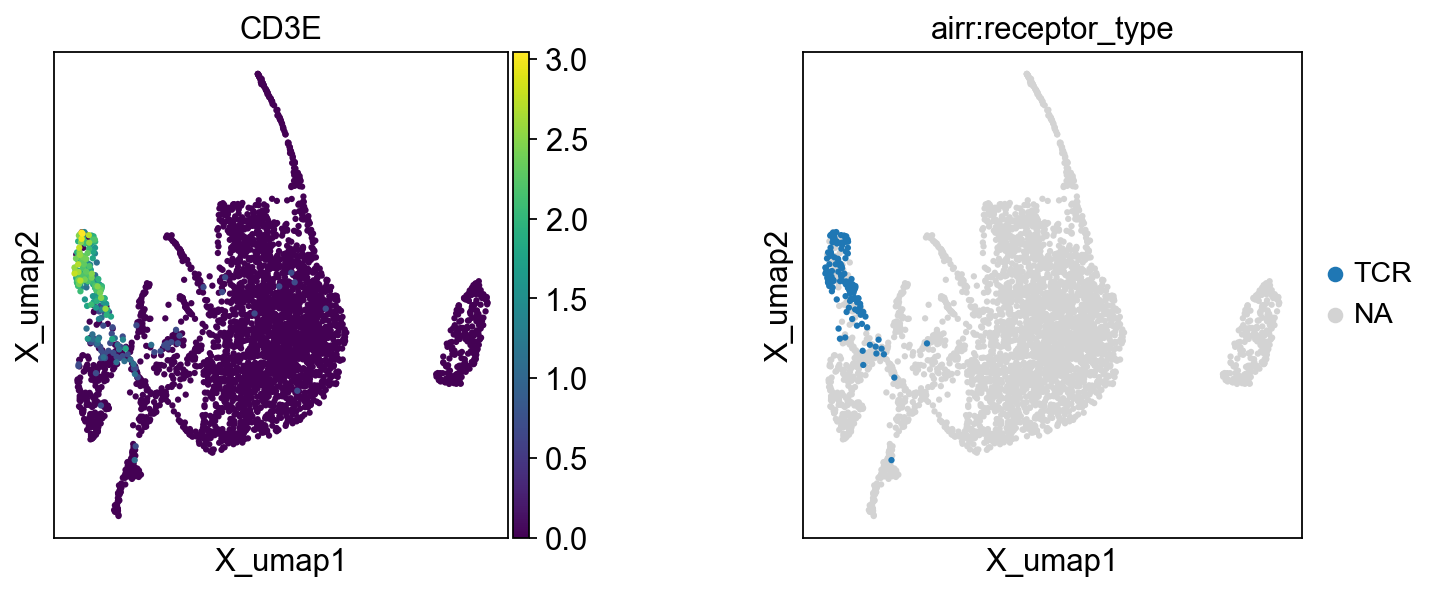

In [17]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={"wspace": 0.5})
mu.pl.embedding(mdata, basis="gex:umap", color=["CD3E"], ax=ax0, show=False)
mu.pl.embedding(mdata, basis="gex:umap", color=["airr:receptor_type"], ax=ax1)

# Combining multiple samples

MuData currently does not implement a concat function (see scverse/mudata#20). Therefore, we need to first concatenate gene expression and AIRR data separately and create the MuData object as the last step.

In [24]:
# define sample metadata. Usually read from a file.
samples = {
    "C144": {"group": "mild"},
    "C146": {"group": "severe"},
    "C149": {"group": "healthy control"},
}

In [25]:
# Create a list of AnnData objects (one for each sample)
adatas_tcr = {}
adatas_gex = {}
for sample, sample_meta in samples.items():
    gex_file = glob(f"dataset/GSE145926_RAW/*{sample}*.h5")[0]
    tcr_file = glob(f"dataset/GSE145926_RAW/*{sample}*.csv.gz")[0]
    adata_gex = sc.read_10x_h5(gex_file)
    adata_tcr = ir.io.read_10x_vdj(tcr_file)
    # concatenation only works with unique gene names
    adata_gex.var_names_make_unique()
    adatas_tcr[sample] = adata_tcr
    adatas_gex[sample] = adata_gex

reading dataset/GSE145926_RAW/GSM4339772_C144_filtered_feature_bc_matrix.h5
 (0:00:00)
reading dataset/GSE145926_RAW/GSM4339774_C146_filtered_feature_bc_matrix.h5


/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
reading dataset/GSE145926_RAW/GSM4475052_C149_filtered_feature_bc_matrix.h5


/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)


/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [26]:
adatas_tcr

{'C144': AnnData object with n_obs × n_vars = 136 × 0
     uns: 'scirpy_version'
     obsm: 'airr',
 'C146': AnnData object with n_obs × n_vars = 54 × 0
     uns: 'scirpy_version'
     obsm: 'airr',
 'C149': AnnData object with n_obs × n_vars = 391 × 0
     uns: 'scirpy_version'
     obsm: 'airr'}

In [27]:
# Merge anndata objects
adata_gex = anndata.concat(adatas_gex, index_unique="_")
adata_tcr = anndata.concat(adatas_tcr, index_unique="_")
mdata = mu.MuData({"gex": adata_gex, "airr": adata_tcr})

# Set global metadata on `mdata.obs`
mdata.obs["sample"] = mdata.obs_names.to_series().str.split("_", expand=True)[1]
mdata.obs["group"] = mdata.obs["sample"].map(lambda x: samples[x]["group"])

/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/anndata/_core/merge.py:1015: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  concat_indices = concat_indices.str.cat(label_col.map(str), sep=index_unique)
/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/anndata/_core/merge.py:1015: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  concat_indices = concat_indices.str.cat(label_col.map(str), sep=index_unique)
/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to 

In [29]:
mdata

MuData object with n_obs × n_vars = 10715 × 33539
  obs:	'sample', 'group'
  2 modalities
    gex:	10706 x 33539
    airr:	581 x 0
      obsm:	'airr'

In [30]:
mdata.obs

sample   group
AAACCTGAGCTAGTGG-1_C144   C144    mild
AAACCTGCAGCCTTTC-1_C144   C144    mild
AAACCTGCAGCTGTGC-1_C144   C144    mild
AAACCTGGTCTAGTGT-1_C144   C144    mild
AAACCTGGTGACTCAT-1_C144   C144    mild
...                        ...     ...
CTCTAATTCATGCTCC-1_C146   C146  severe
CTGAAGTGTATAGTAG-1_C146   C146  severe
GACTAACCAGTTAACC-1_C146   C146  severe
TAAACCGCACTGAAGG-1_C146   C146  severe
TTAGGACCAGCTGCAC-1_C146   C146  severe

[10715 rows x 2 columns]

In [35]:
sc.pp.log1p(mdata["gex"])
sc.pp.pca(mdata["gex"], svd_solver="arpack")
sc.pp.neighbors(mdata["gex"])
sc.tl.umap(mdata["gex"])
ir.pp.index_chains(mdata)
ir.tl.chain_qc(mdata)

computing PCA
    with n_comps=50
    finished (0:00:07)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:12)
computing UMAP
    finished (0:00:05)


100%|██████████| 1/1 [00:00<00:00, 43.98it/s]

Stored result in `mdata.obs["airr:receptor_type"]`.
Stored result in `mdata.obs["airr:receptor_subtype"]`.
Stored result in `mdata.obs["airr:chain_pairing"]`.


/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/mowp/mambaforge/envs/s

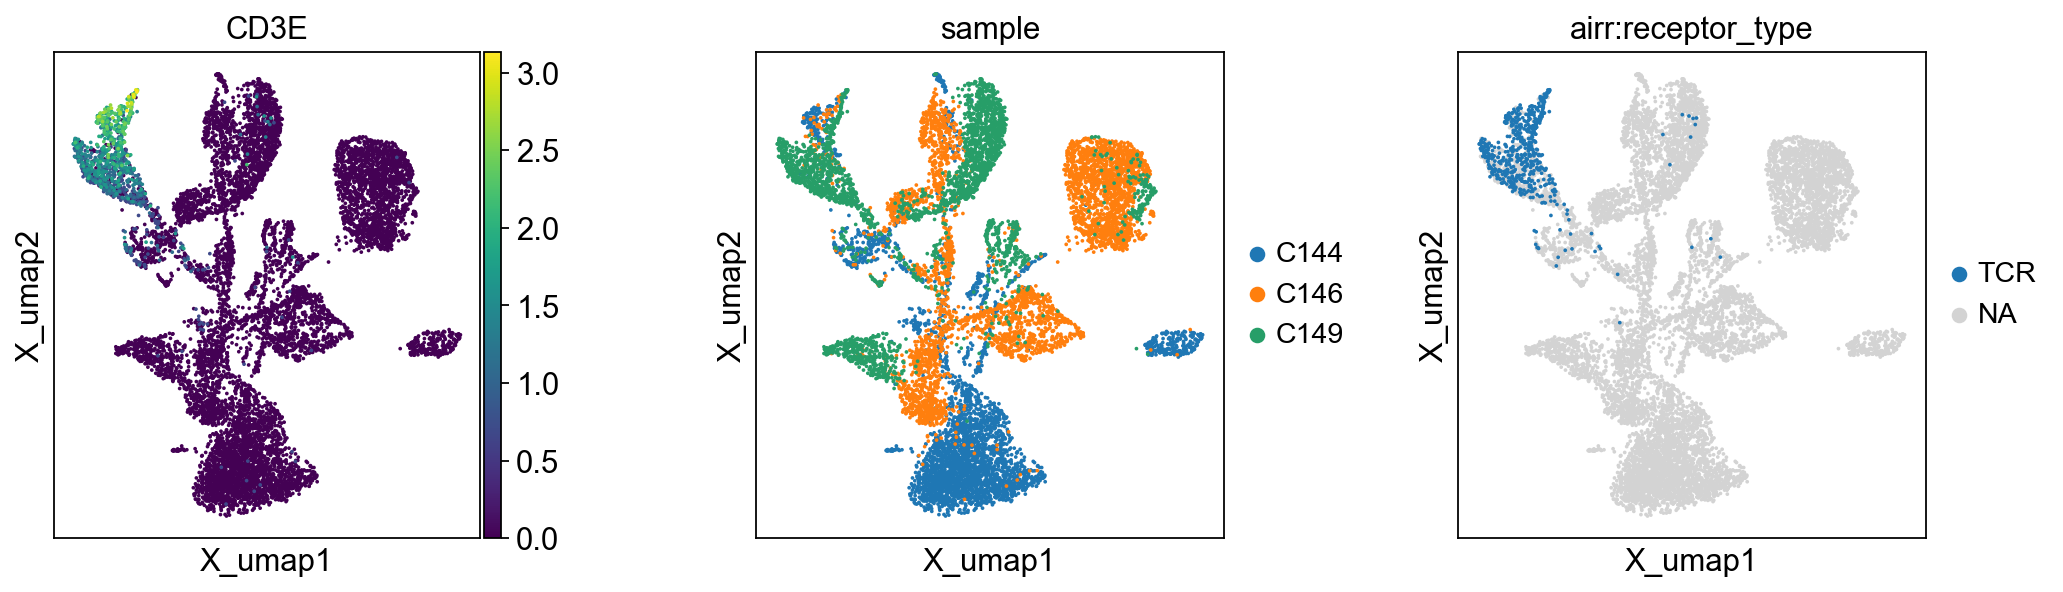

In [36]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 4), gridspec_kw={"wspace": 0.5})
mu.pl.embedding(mdata, basis="gex:umap", color="CD3E", ax=ax0, show=False)
mu.pl.embedding(mdata, basis="gex:umap", color="sample", ax=ax1, show=False)
mu.pl.embedding(mdata, basis="gex:umap", color="airr:receptor_type", ax=ax2)

# Analysis of 3k T cells from cancer

In [37]:
mdata = ir.datasets.wu2020_3k()

100%|█████████████████████████████████████| 17.3M/17.3M [00:00<00:00, 11.6GB/s]
/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [39]:
mdata

MuData object with n_obs × n_vars = 3000 × 30727
  2 modalities
    gex:	3000 x 30727
      obs:	'cluster_orig', 'patient', 'sample', 'source'
      uns:	'cluster_orig_colors'
      obsm:	'X_umap_orig'
    airr:	3000 x 0
      obs:	'high_confidence', 'is_cell', 'clonotype_orig'
      obsm:	'airr'

In [40]:
mdata['airr'].obs

high_confidence  is_cell    clonotype_orig
LN1_GTAGGCCAGCGTAGTG-1             True     True     lung1.tn.C223
RN2_AGAGCGACAGATTGCT-1             True     True  renal2.tnb.C1362
LN1_GTCATTTCAATGAAAC-1             True     True      lung1.tn.C25
LN2_GACACGCAGGTAGCTG-2             True     True    lung2.tn.C2452
LN2_GCACTCTCAGGGATTG-2             True     True    lung2.tn.C5631
...                                 ...      ...               ...
RT3_GCAGTTAGTATGAAAC-1             True     True   renal3.tnb.C176
LT1_GACGTGCTCTCAAGTG-1             True     True     lung1.tn.C151
ET3_GCTGGGTAGACCTTTG-1             True     True      endo3.tn.C76
RT1_TAAGAGATCCTTAATC-1             True     True    renal1.tnb.C83
LN2_TCTGAGAAGGACACCA-2             True     True    lung2.tn.C6211

[3000 rows x 3 columns]

## Preprocessing Transcriptomics data

In [41]:
sc.pp.filter_genes(mdata["gex"], min_cells=10)
sc.pp.filter_cells(mdata["gex"], min_genes=100)

filtered out 18877 genes that are detected in less than 10 cells


/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [42]:
sc.pp.normalize_per_cell(mdata["gex"])
sc.pp.log1p(mdata["gex"])
sc.pp.highly_variable_genes(mdata["gex"], flavor="cell_ranger", n_top_genes=5000)
sc.tl.pca(mdata["gex"])
sc.pp.neighbors(mdata["gex"])

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
computing PCA
    on highly variable genes
    with n_comps=50


/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:247: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)


In [43]:
mdata["gex"].obsm["X_umap"] = mdata["gex"].obsm["X_umap_orig"]

In [45]:
mapping = {
    "nan": "other",
    "3.1-MT": "other",
    "4.1-Trm": "CD4_Trm",
    "4.2-RPL32": "CD4_RPL32",
    "4.3-TCF7": "CD4_TCF7",
    "4.4-FOS": "CD4_FOSS",
    "4.5-IL6ST": "CD4_IL6ST",
    "4.6a-Treg": "CD4_Treg",
    "4.6b-Treg": "CD4_Treg",
    "8.1-Teff": "CD8_Teff",
    "8.2-Tem": "CD8_Tem",
    "8.3a-Trm": "CD8_Trm",
    "8.3b-Trm": "CD8_Trm",
    "8.3c-Trm": "CD8_Trm",
    "8.4-Chrom": "other",
    "8.5-Mitosis": "other",
    "8.6-KLRB1": "other",
}
mdata["gex"].obs["cluster"] = mdata["gex"].obs["cluster_orig"].map(mapping)

In [47]:
mdata.update()

In [48]:
mdata

MuData object with n_obs × n_vars = 3000 × 11850
  2 modalities
    gex:	3000 x 11850
      obs:	'cluster_orig', 'patient', 'sample', 'source', 'n_genes', 'n_counts', 'cluster'
      var:	'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'cluster_orig_colors', 'log1p', 'hvg', 'pca', 'neighbors'
      obsm:	'X_umap_orig', 'X_pca', 'X_umap'
      varm:	'PCs'
      obsp:	'distances', 'connectivities'
    airr:	3000 x 0
      obs:	'high_confidence', 'is_cell', 'clonotype_orig'
      obsm:	'airr'

/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.p

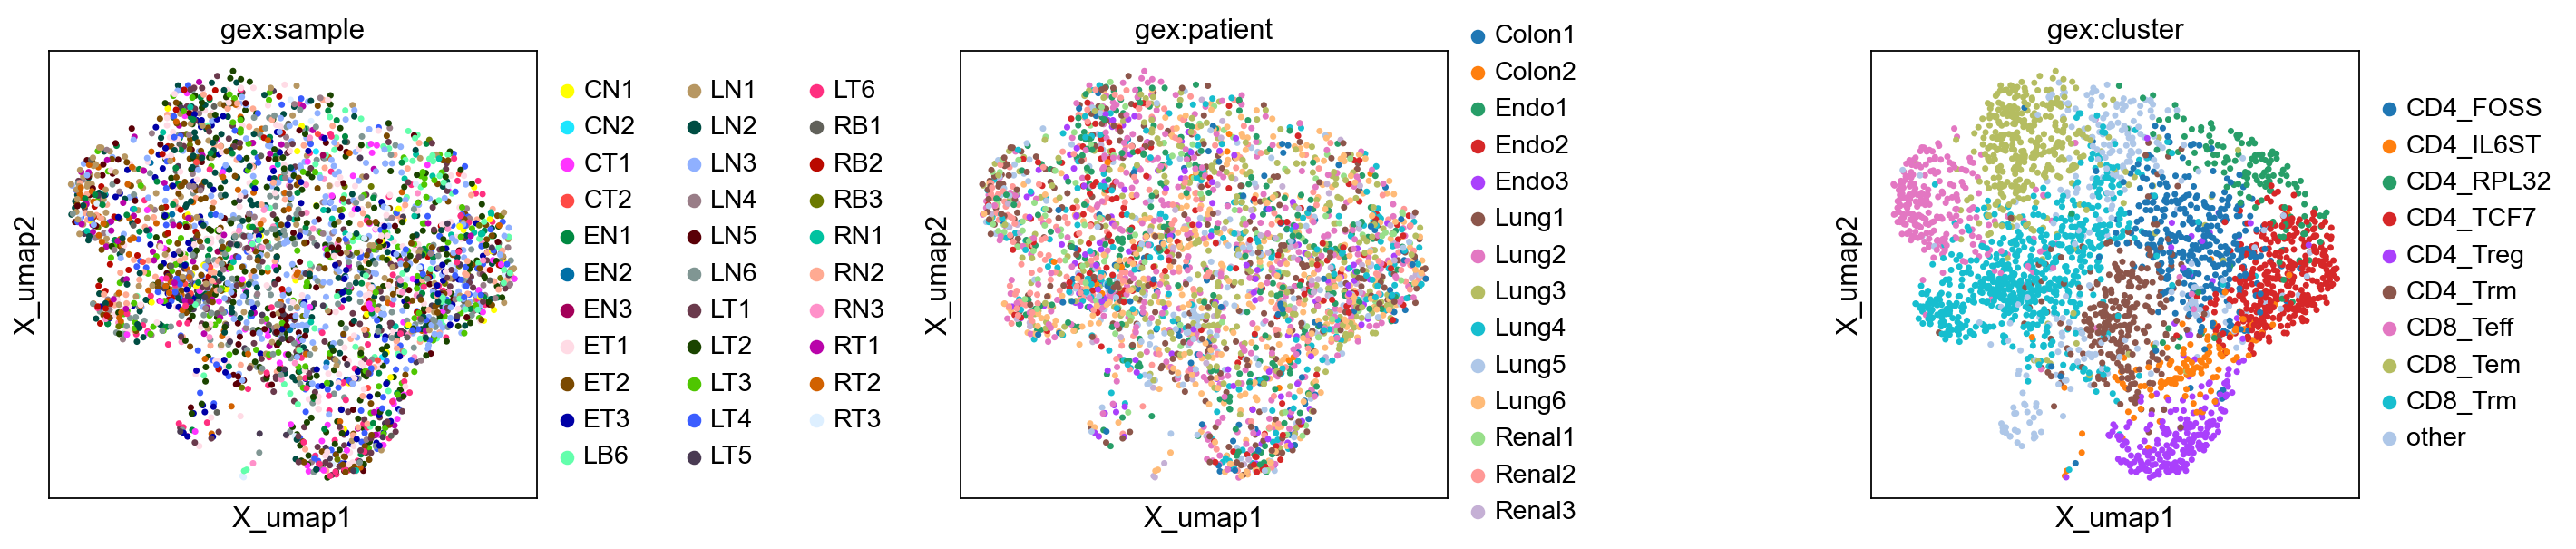

/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


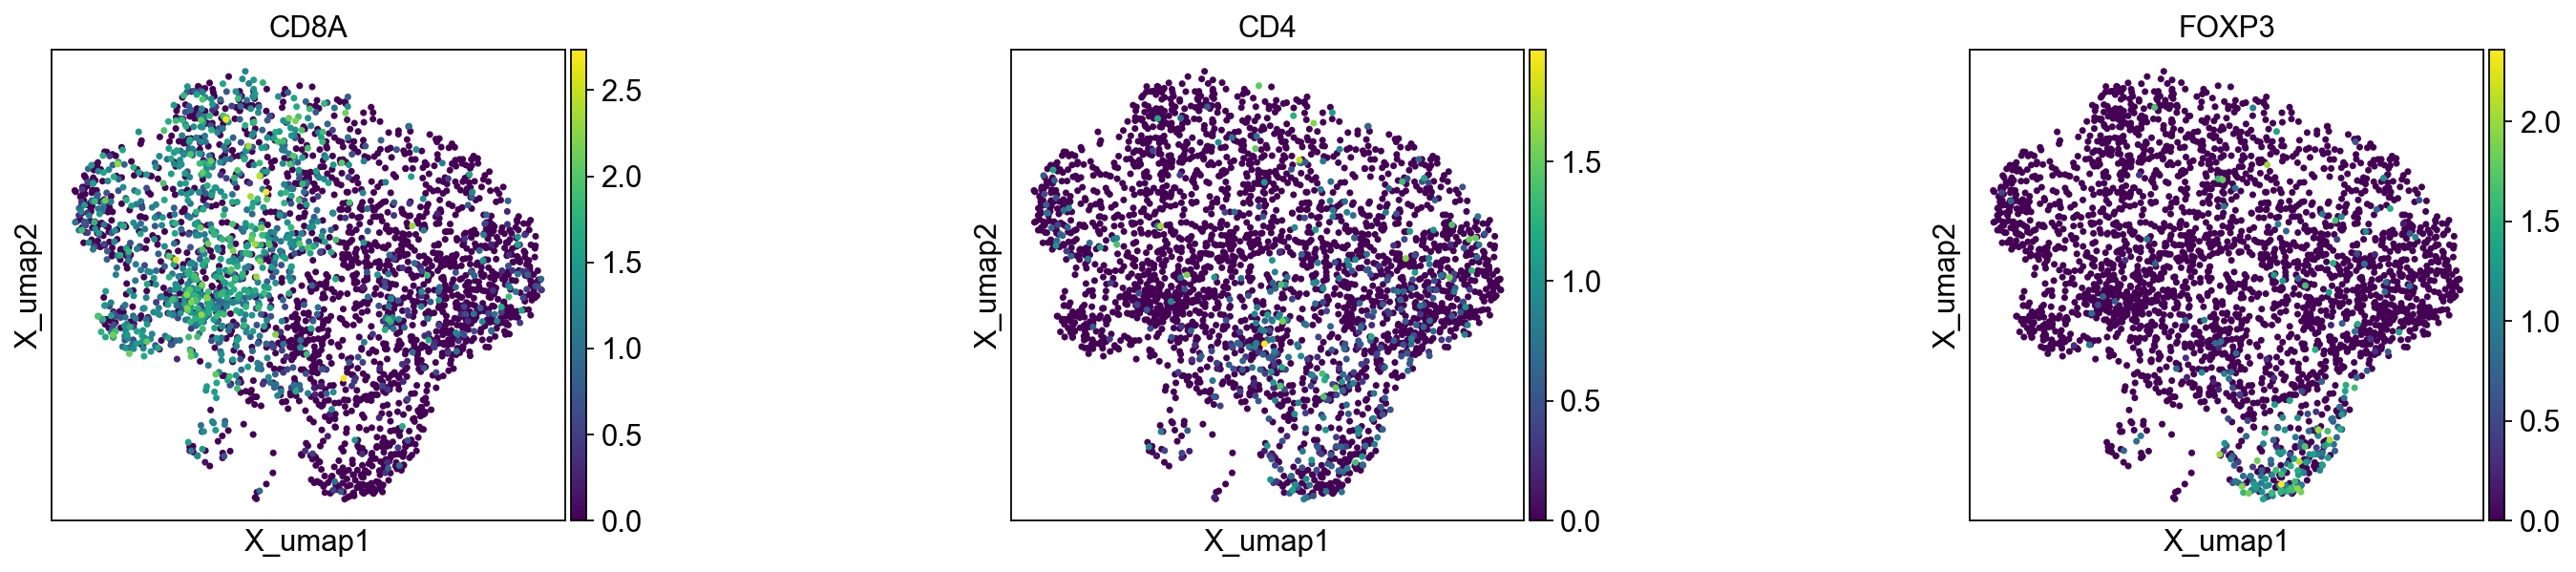

In [49]:
mu.pl.embedding(
    mdata,
    basis="gex:umap",
    color=["gex:sample", "gex:patient", "gex:cluster"],
    ncols=3,
    wspace=0.7,
)
mu.pl.embedding(
    mdata,
    basis="gex:umap",
    color=["CD8A", "CD4", "FOXP3"],
    ncols=3,
    wspace=0.7,
)

## Creating chain indices

In [55]:
ir.pp.index_chains(mdata)

100%|██████████| 1/1 [00:00<00:00,  8.20it/s]


## TCR Quality Control

In [56]:
ir.tl.chain_qc(mdata)

Stored result in `mdata.obs["airr:receptor_type"]`.
Stored result in `mdata.obs["airr:receptor_subtype"]`.
Stored result in `mdata.obs["airr:chain_pairing"]`.


In [57]:
mdata['airr'].obs

high_confidence  is_cell    clonotype_orig  \
LN1_GTAGGCCAGCGTAGTG-1             True     True     lung1.tn.C223   
RN2_AGAGCGACAGATTGCT-1             True     True  renal2.tnb.C1362   
LN1_GTCATTTCAATGAAAC-1             True     True      lung1.tn.C25   
LN2_GACACGCAGGTAGCTG-2             True     True    lung2.tn.C2452   
LN2_GCACTCTCAGGGATTG-2             True     True    lung2.tn.C5631   
...                                 ...      ...               ...   
RT3_GCAGTTAGTATGAAAC-1             True     True   renal3.tnb.C176   
LT1_GACGTGCTCTCAAGTG-1             True     True     lung1.tn.C151   
ET3_GCTGGGTAGACCTTTG-1             True     True      endo3.tn.C76   
RT1_TAAGAGATCCTTAATC-1             True     True    renal1.tnb.C83   
LN2_TCTGAGAAGGACACCA-2             True     True    lung2.tn.C6211   

                       receptor_type receptor_subtype chain_pairing  
LN1_GTAGGCCAGCGTAGTG-1           TCR          TRA+TRB    orphan VDJ  
RN2_AGAGCGACAGATTGCT-1           TCR          TRA+TRB   single pair  
LN1_GTCATTTCAATGAAAC-1           TCR          TRA+TRB   single pair  
LN2_GACACGCAGGTAGCTG-2           TCR          TRA+TRB    orphan VDJ  
LN2_GCACTCTCAGGGATTG-2           TCR          TRA+TRB   single pair  
...                              ...              ...           ...  
RT3_GCAGTTAGTATGAAAC-1           TCR          TRA+TRB   single pair  
LT1_GACGTGCTCTCAAGTG-1           TCR          TRA+TRB     orphan VJ  
ET3_GCTGGGTAGACCTTTG-1           TCR          TRA+TRB    orphan VDJ  
RT1_TAAGAGATCCTTAATC-1           TCR          TRA+TRB   single pair  
LN2_TCTGAGAAGGACACCA-2           TCR          TRA+TRB   single pair  

[3000 rows x 6 columns]

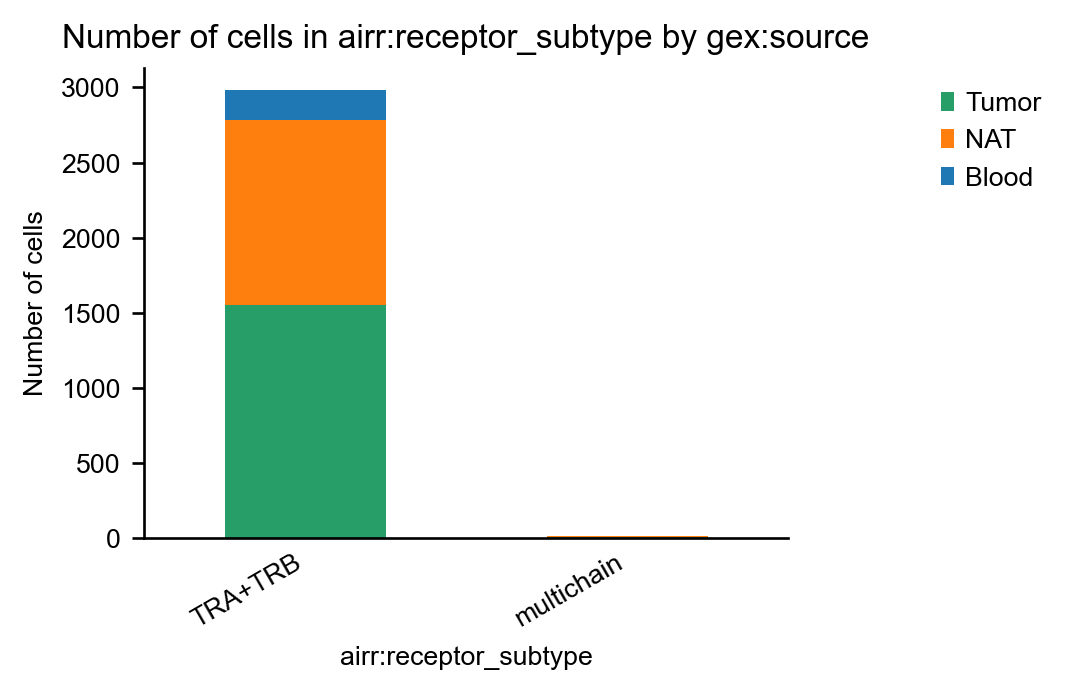

In [58]:
_ = ir.pl.group_abundance(
    mdata, groupby="airr:receptor_subtype", target_col="gex:source"
)

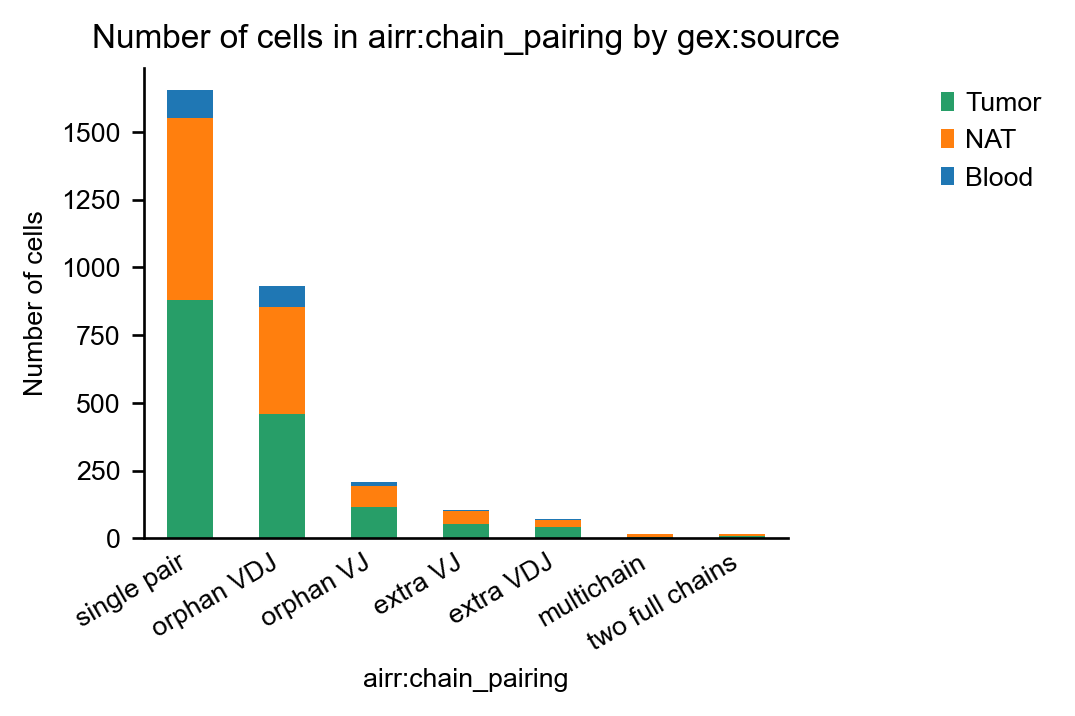

In [59]:
_ = ir.pl.group_abundance(mdata, groupby="airr:chain_pairing", target_col="gex:source")

In [62]:
print(
    "Fraction of cells with more than one pair of TCRs: {:.2f}".format(
        np.sum(
            mdata.obs["airr:chain_pairing"].isin(
                ["extra VJ", "extra VDJ", "two full chains", "multichain"]
            )
        )
        / mdata["airr"].n_obs
    )
)

Fraction of cells with more than one pair of TCRs: 0.07


/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1169: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if groups and is_categorical_dtype(values):
/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/mowp/mambaforge

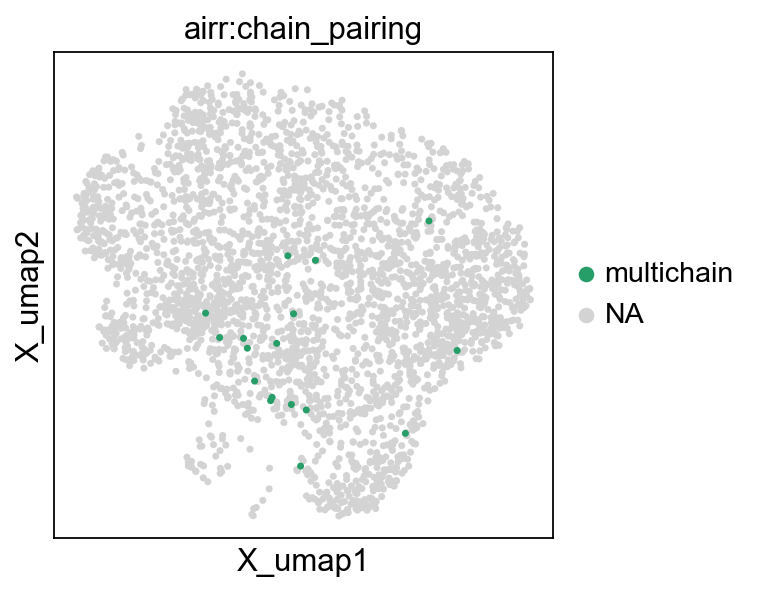

In [63]:
# visualize the Multichain-cells on the UMAP plot and exclude them from downstream analysis:
mu.pl.embedding(
    mdata, basis="gex:umap", color="airr:chain_pairing", groups="multichain"
)

In [65]:
mu.pp.filter_obs(mdata, "airr:chain_pairing", lambda x: x != "multichain")

In [66]:
# use the chain_pairing information to exclude all cells that don’t have at least one full pair of receptor sequences
mu.pp.filter_obs(
    mdata, "airr:chain_pairing", lambda x: ~np.isin(x, ["orphan VDJ", "orphan VJ"])
)

In [67]:
mdata

MuData object with n_obs × n_vars = 1845 × 11850
  2 modalities
    gex:	1845 x 11850
      obs:	'cluster_orig', 'patient', 'sample', 'source', 'n_genes', 'n_counts', 'cluster'
      var:	'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'cluster_orig_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'gex:sample_colors', 'gex:patient_colors', 'gex:cluster_colors', 'airr:chain_pairing_colors'
      obsm:	'X_umap_orig', 'X_pca', 'X_umap'
      varm:	'PCs'
      obsp:	'distances', 'connectivities'
    airr:	1845 x 0
      obs:	'high_confidence', 'is_cell', 'clonotype_orig', 'receptor_type', 'receptor_subtype', 'chain_pairing'
      uns:	'chain_indices'
      obsm:	'airr', 'chain_indices'

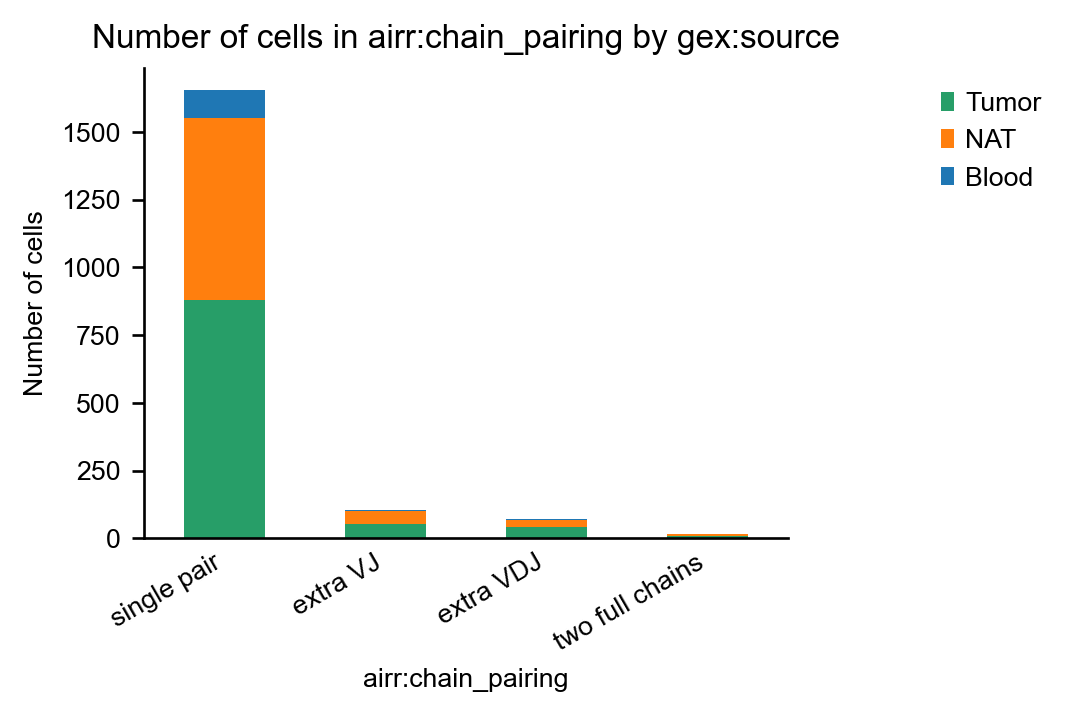

In [68]:
ax = ir.pl.group_abundance(mdata, groupby="airr:chain_pairing", target_col="gex:source")

## Define clonotypes and clonotype clusters

Scirpy implements a network-based approach for clonotype definition. The steps to create and visualize the clonotype-network are analogous to the construction of a neighborhood graph from transcriptomics data with Scanpy.


### Compute CDR3 neighborhood graph and define clonotypes

In [69]:
# using default parameters, `ir_dist` will compute nucleotide sequence identity
ir.pp.ir_dist(mdata)  # Compute sequence-based distance matrices for all VJ and VDJ sequences.
ir.tl.define_clonotypes(mdata, receptor_arms="all", dual_ir="primary_only")  #  add a clone_id and clone_id_size column to adata.obs

Computing sequence x sequence distance matrix for VJ sequences.
Computing sequence x sequence distance matrix for VDJ sequences.
Initializing lookup tables. 
Computing clonotype x clonotype distances.


100%|██████████| 1526/1526 [00:01<00:00, 908.52it/s]

Stored result in `mdata.obs["airr:clone_id"]`.
Stored result in `mdata.obs["airr:clone_id_size"]`.


In [72]:
mdata['airr'].obs

high_confidence  is_cell    clonotype_orig  \
RN2_AGAGCGACAGATTGCT-1             True     True  renal2.tnb.C1362   
LN1_GTCATTTCAATGAAAC-1             True     True      lung1.tn.C25   
LN2_GCACTCTCAGGGATTG-2             True     True    lung2.tn.C5631   
LN4_GAAACTCTCATCATTC-1             True     True    lung4.tn.C3988   
LT6_AGTTGGTGTACCGCTG-1             True     True    lung6.tnb.C999   
...                                 ...      ...               ...   
LT6_CTCAGAATCAGAGGTG-1             True     True    lung6.tnb.C122   
LT5_GACCTGGAGGAGTAGA-1             True     True    lung5.tn.C1505   
RT3_GCAGTTAGTATGAAAC-1             True     True   renal3.tnb.C176   
RT1_TAAGAGATCCTTAATC-1             True     True    renal1.tnb.C83   
LN2_TCTGAGAAGGACACCA-2             True     True    lung2.tn.C6211   

                       receptor_type receptor_subtype chain_pairing clone_id  \
RN2_AGAGCGACAGATTGCT-1           TCR          TRA+TRB   single pair        0   
LN1_GTCATTTCAATGAAAC-1           TCR          TRA+TRB   single pair        1   
LN2_GCACTCTCAGGGATTG-2           TCR          TRA+TRB   single pair        2   
LN4_GAAACTCTCATCATTC-1           TCR          TRA+TRB   single pair        3   
LT6_AGTTGGTGTACCGCTG-1           TCR          TRA+TRB   single pair        4   
...                              ...              ...           ...      ...   
LT6_CTCAGAATCAGAGGTG-1           TCR          TRA+TRB   single pair     1522   
LT5_GACCTGGAGGAGTAGA-1           TCR          TRA+TRB   single pair     1523   
RT3_GCAGTTAGTATGAAAC-1           TCR          TRA+TRB   single pair      928   
RT1_TAAGAGATCCTTAATC-1           TCR          TRA+TRB   single pair     1524   
LN2_TCTGAGAAGGACACCA-2           TCR          TRA+TRB   single pair     1525   

                        clone_id_size  
RN2_AGAGCGACAGATTGCT-1              1  
LN1_GTCATTTCAATGAAAC-1              1  
LN2_GCACTCTCAGGGATTG-2              1  
LN4_GAAACTCTCATCATTC-1              1  
LT6_AGTTGGTGTACCGCTG-1              1  
...                               ...  
LT6_CTCAGAATCAGAGGTG-1              1  
LT5_GACCTGGAGGAGTAGA-1              1  
RT3_GCAGTTAGTATGAAAC-1              4  
RT1_TAAGAGATCCTTAATC-1              1  
LN2_TCTGAGAAGGACACCA-2              1  

[1845 rows x 8 columns]

In [73]:
ir.tl.clonotype_network(mdata, min_cells=2)  # min_cells parameter to >=2, to prevent the singleton clonotypes from cluttering the network

In [74]:
mdata.obs.groupby("gex:source", dropna=False).size()

/tmp/ipykernel_1373965/1879210206.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mdata.obs.groupby("gex:source", dropna=False).size()


gex:source
Blood    107
NAT      756
Tumor    982
dtype: int64

The resulting plot is a network, where each dot represents cells with identical receptor configurations. As we define clonotypes as cells with identical CDR3-sequences, each dot is also a clonotype. For each clonotype, the numeric clonotype id is shown in the graph. The size of each dot refers to the number of cells with the same receptor configurations. Categorical variables can be visualized as pie charts.

/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/scirpy/pl/_clonotypes.py:194: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(color_col) and color_col.nunique() >= 50:
/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/scirpy/pl/_clonotypes.py:466: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if isinstance(color, str) and color in obs and not is_categorical_dtype(obs[color]):
/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/scirpy/pl/_clonotypes.py:471: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if isinstance(color, str) and color in obs and is_categorical_dtype(obs[color]):


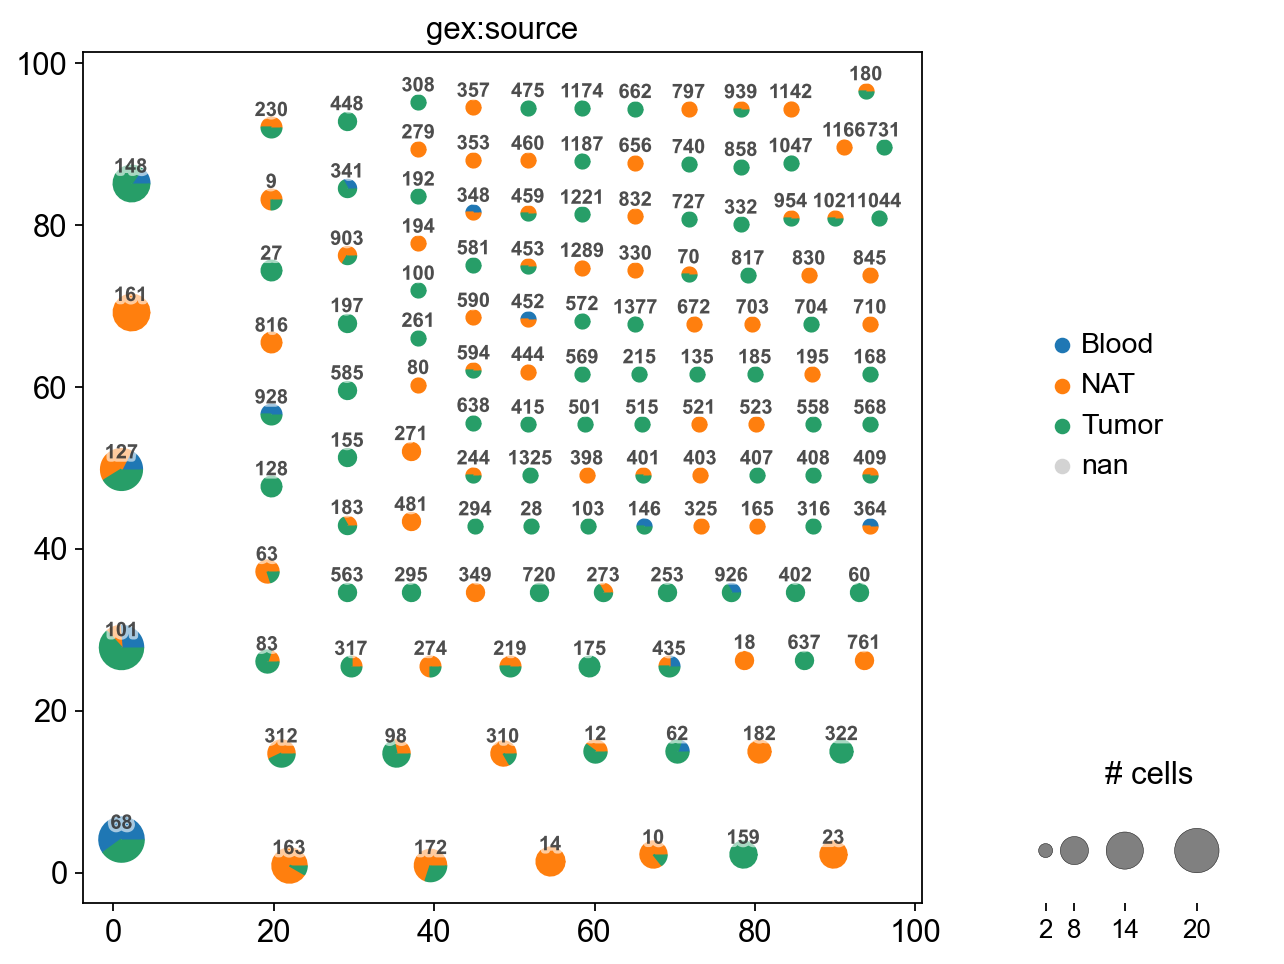

In [75]:
_ = ir.pl.clonotype_network(
    mdata, color="gex:source", base_size=20, label_fontsize=9, panel_size=(7, 7)
)

### Re-compute CDR3 neighborhood graph and define clonotype clusters

In [76]:
ir.pp.ir_dist(
    mdata,
    metric="alignment",
    sequence="aa",
    cutoff=15,
)

Computing sequence x sequence distance matrix for VJ sequences.


100%|██████████| 496/496 [00:01<00:00, 262.27it/s]


Computing sequence x sequence distance matrix for VDJ sequences.


100%|██████████| 496/496 [00:01<00:00, 266.67it/s]


In [77]:
ir.tl.define_clonotype_clusters(
    mdata, sequence="aa", metric="alignment", receptor_arms="all", dual_ir="any"
)

Initializing lookup tables. 
Computing clonotype x clonotype distances.


100%|██████████| 1549/1549 [00:04<00:00, 321.19it/s]


Stored result in `mdata.obs["airr:cc_aa_alignment"]`.
Stored result in `mdata.obs["airr:cc_aa_alignment_size"]`.


In [78]:
ir.tl.clonotype_network(mdata, min_cells=3, sequence="aa", metric="alignment")

Compared to the previous plot, we observere several connected dots. Each fully connected subnetwork represents a “clonotype cluster”, each dot still represents cells with identical receptor configurations.

/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/scirpy/pl/_clonotypes.py:194: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(color_col) and color_col.nunique() >= 50:
/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/scirpy/pl/_clonotypes.py:466: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if isinstance(color, str) and color in obs and not is_categorical_dtype(obs[color]):
/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/scirpy/pl/_clonotypes.py:471: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if isinstance(color, str) and color in obs and is_categorical_dtype(obs[color]):


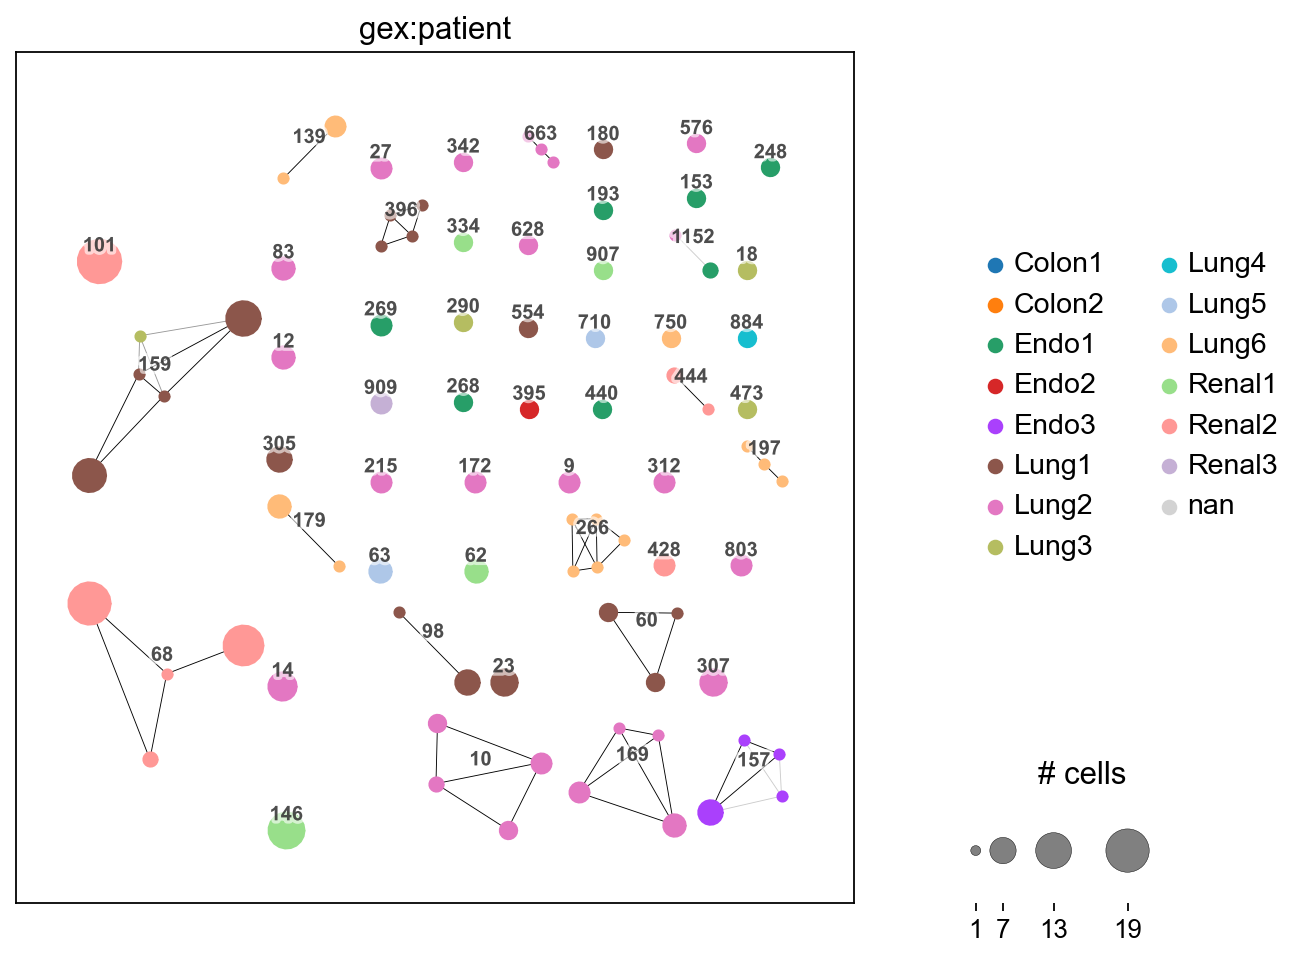

In [79]:
_ = ir.pl.clonotype_network(
    mdata, color="gex:patient", label_fontsize=9, panel_size=(7, 7), base_size=20
)

The dots are colored by patient. We observe, that for instance, clonotypes 101 and 68 (left top and bottom) are private, i.e. they contain cells from a single patient only. On the other hand, clonotype 159 (left middle) is public, i.e. it is shared across patients Lung1 and Lung3.

We can now extract information (e.g. CDR3-sequences) from a specific clonotype cluster by subsetting MuData. By extracting the CDR3 sequences of clonotype cluster 159, we retreive five different receptor configurations with different numbers of cells, corresponding to the five points in the graph.

In [80]:
with ir.get.airr_context(mdata, "junction_aa", ["VJ_1", "VDJ_1", "VJ_2", "VDJ_2"]):
    cdr3_ct_159 = (
        # TODO astype(str) is required due to a bug in pandas ignoring `dropna=False`. It seems fixed in pandas 2.x
        mdata.obs.loc[lambda x: x["airr:cc_aa_alignment"] == "159"]
        .astype(str)
        .groupby(
            [
                "VJ_1_junction_aa",
                "VDJ_1_junction_aa",
                "VJ_2_junction_aa",
                "VDJ_2_junction_aa",
                "airr:receptor_subtype",
            ],
            observed=True,
            dropna=False,
        )
        .size()
        .reset_index(name="n_cells")
    )
cdr3_ct_159

VJ_1_junction_aa VDJ_1_junction_aa VJ_2_junction_aa VDJ_2_junction_aa  \
0    CAGKAGNTGKLIF     CASSYQGSTEAFF              nan               nan   
1    CAGKSGNTGKLIF     CASSYQGATEAFF  CATDPRRSTGNQFYF               nan   
2    CAGKSGNTGKLIF     CASSYQGATEAFF              nan               nan   
3  CATDPRRSTGNQFYF     CASSYQGATEAFF    CAGKSGNTGKLIF               nan   
4  CATDPRRSTGNQFYF     CASSYQGATEAFF              nan               nan   

  airr:receptor_subtype  n_cells  
0               TRA+TRB        1  
1               TRA+TRB        1  
2               TRA+TRB       12  
3               TRA+TRB        1  
4               TRA+TRB       11

### Including the V-gene in clonotype definition

Using the paramter use_v_gene in define_clonotypes(), we can enforce clonotypes (or clonotype clusters) to have the same V-gene, and, therefore, the same CDR1 and 2 regions. Let’s look for clonotype clusters with different V genes:

In [92]:
ir.tl.define_clonotype_clusters(
    mdata,
    sequence="aa",
    metric="alignment",
    receptor_arms="all",
    dual_ir="any",
    same_v_gene=True,
    key_added="cc_aa_alignment_same_v",
)

Initializing lookup tables. 
Computing clonotype x clonotype distances.


100%|██████████| 1549/1549 [00:05<00:00, 290.65it/s]

Stored result in `mdata.obs["airr:cc_aa_alignment_same_v"]`.
Stored result in `mdata.obs["airr:cc_aa_alignment_same_v_size"]`.


In [95]:
mdata['airr'].obs

high_confidence  is_cell    clonotype_orig  \
RN2_AGAGCGACAGATTGCT-1             True     True  renal2.tnb.C1362   
LN1_GTCATTTCAATGAAAC-1             True     True      lung1.tn.C25   
LN2_GCACTCTCAGGGATTG-2             True     True    lung2.tn.C5631   
LN4_GAAACTCTCATCATTC-1             True     True    lung4.tn.C3988   
LT6_AGTTGGTGTACCGCTG-1             True     True    lung6.tnb.C999   
...                                 ...      ...               ...   
LT6_CTCAGAATCAGAGGTG-1             True     True    lung6.tnb.C122   
LT5_GACCTGGAGGAGTAGA-1             True     True    lung5.tn.C1505   
RT3_GCAGTTAGTATGAAAC-1             True     True   renal3.tnb.C176   
RT1_TAAGAGATCCTTAATC-1             True     True    renal1.tnb.C83   
LN2_TCTGAGAAGGACACCA-2             True     True    lung2.tn.C6211   

                       receptor_type receptor_subtype chain_pairing clone_id  \
RN2_AGAGCGACAGATTGCT-1           TCR          TRA+TRB   single pair        0   
LN1_GTCATTTCAATGAAAC-1           TCR          TRA+TRB   single pair        1   
LN2_GCACTCTCAGGGATTG-2           TCR          TRA+TRB   single pair        2   
LN4_GAAACTCTCATCATTC-1           TCR          TRA+TRB   single pair        3   
LT6_AGTTGGTGTACCGCTG-1           TCR          TRA+TRB   single pair        4   
...                              ...              ...           ...      ...   
LT6_CTCAGAATCAGAGGTG-1           TCR          TRA+TRB   single pair     1522   
LT5_GACCTGGAGGAGTAGA-1           TCR          TRA+TRB   single pair     1523   
RT3_GCAGTTAGTATGAAAC-1           TCR          TRA+TRB   single pair      928   
RT1_TAAGAGATCCTTAATC-1           TCR          TRA+TRB   single pair     1524   
LN2_TCTGAGAAGGACACCA-2           TCR          TRA+TRB   single pair     1525   

                        clone_id_size cc_aa_alignment  cc_aa_alignment_size  \
RN2_AGAGCGACAGATTGCT-1              1               0                     1   
LN1_GTCATTTCAATGAAAC-1              1               1                     1   
LN2_GCACTCTCAGGGATTG-2              1               2                     1   
LN4_GAAACTCTCATCATTC-1              1               3                     1   
LT6_AGTTGGTGTACCGCTG-1              1               4                     1   
...                               ...             ...                   ...   
LT6_CTCAGAATCAGAGGTG-1              1            1483                     1   
LT5_GACCTGGAGGAGTAGA-1              1            1484                     1   
RT3_GCAGTTAGTATGAAAC-1              4             909                     4   
RT1_TAAGAGATCCTTAATC-1              1            1485                     1   
LN2_TCTGAGAAGGACACCA-2              1            1486                     1   

                       cc_aa_alignment_same_v  cc_aa_alignment_same_v_size  
RN2_AGAGCGACAGATTGCT-1                      0                            1  
LN1_GTCATTTCAATGAAAC-1                      1                            1  
LN2_GCACTCTCAGGGATTG-2                      2                            1  
LN4_GAAACTCTCATCATTC-1                      3                            1  
LT6_AGTTGGTGTACCGCTG-1                      4                            1  
...                                       ...                          ...  
LT6_CTCAGAATCAGAGGTG-1                   1485                            1  
LT5_GACCTGGAGGAGTAGA-1                   1486                            1  
RT3_GCAGTTAGTATGAAAC-1                    910                            4  
RT1_TAAGAGATCCTTAATC-1                   1487                            1  
LN2_TCTGAGAAGGACACCA-2                   1488                            1  

[1845 rows x 12 columns]

In [93]:
# find clonotypes with more than one `clonotype_same_v`
ct_different_v = mdata.obs.groupby("airr:cc_aa_alignment").apply(
    lambda x: x["airr:cc_aa_alignment_same_v"].nunique() > 1
)
ct_different_v = ct_different_v[ct_different_v].index.values.tolist()
ct_different_v

/tmp/ipykernel_1373965/2286538572.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ct_different_v = mdata.obs.groupby("airr:cc_aa_alignment").apply(


['280', '765']

In [94]:
with ir.get.airr_context(mdata, "v_call", ["VJ_1", "VDJ_1"]):
    ct_different_v_df = (
        mdata.obs.loc[
            lambda x: x["airr:cc_aa_alignment"].isin(ct_different_v),
            [
                "airr:cc_aa_alignment",
                "airr:cc_aa_alignment_same_v",
                "VJ_1_v_call",
                "VDJ_1_v_call",
            ],
        ]
        .sort_values("airr:cc_aa_alignment")
        .drop_duplicates()
        .reset_index(drop=True)
    )
ct_different_v_df

airr:cc_aa_alignment airr:cc_aa_alignment_same_v VJ_1_v_call VDJ_1_v_call
0                  280                         280     TRAV8-6      TRBV6-6
1                  280                         788     TRAV8-3        TRBV9
2                  765                         765      TRAV21      TRBV6-6
3                  765                        1071      TRAV21      TRBV6-5

Here, we see that the clonotype clusters 280 and 765 get split into (280, 788) and (765, 1071), respectively, when the same_v_gene flag is set.

在V基因相同的条件下，我们可以看到，clonotype cluster 280和765被分成了两个子集，分别是(280, 788)和(765, 1071)。

## Clonotype analysis

### Clonal expansion
Let’s visualize the number of expanded clonotypes (i.e. clonotypes consisting of more than one cell) by cell-type. The first option is to add a column with the scirpy.tl.clonal_expansion() to adata.obs and overlay it on the UMAP plot.

In [96]:
ir.tl.clonal_expansion(mdata)

Stored result in `mdata.obs["airr:clonal_expansion"]`.


In [97]:
mdata.obs["airr:clonal_expansion"]

RN2_AGAGCGACAGATTGCT-1       1
LN1_GTCATTTCAATGAAAC-1       1
LN2_GCACTCTCAGGGATTG-2       1
LN4_GAAACTCTCATCATTC-1       1
LT6_AGTTGGTGTACCGCTG-1       1
                          ... 
LT6_CTCAGAATCAGAGGTG-1       1
LT5_GACCTGGAGGAGTAGA-1       1
RT3_GCAGTTAGTATGAAAC-1    >= 3
RT1_TAAGAGATCCTTAATC-1       1
LN2_TCTGAGAAGGACACCA-2       1
Name: airr:clonal_expansion, Length: 1845, dtype: object

/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.p

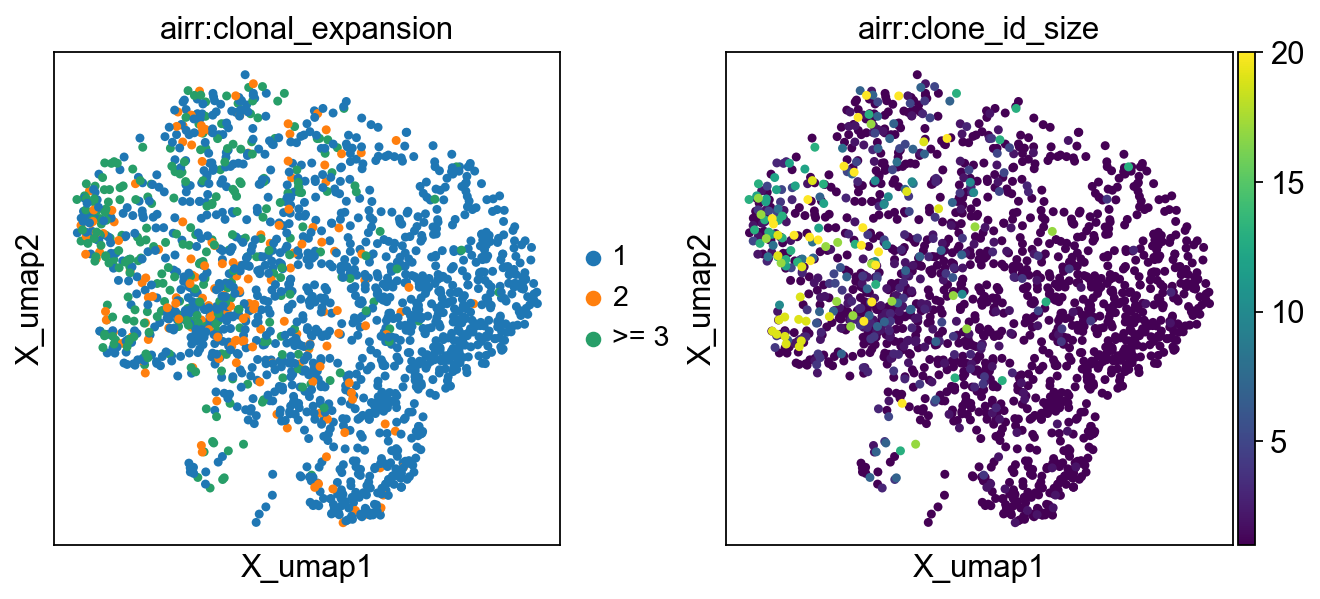

In [98]:
mu.pl.embedding(
    mdata, basis="gex:umap", color=["airr:clonal_expansion", "airr:clone_id_size"]
)

clonal_expansion refers to expansion categories, i.e singleton clonotypes, clonotypes with 2 cells and more than 2 cells. The clonotype_size refers to the absolute number of cells in a clonotype.

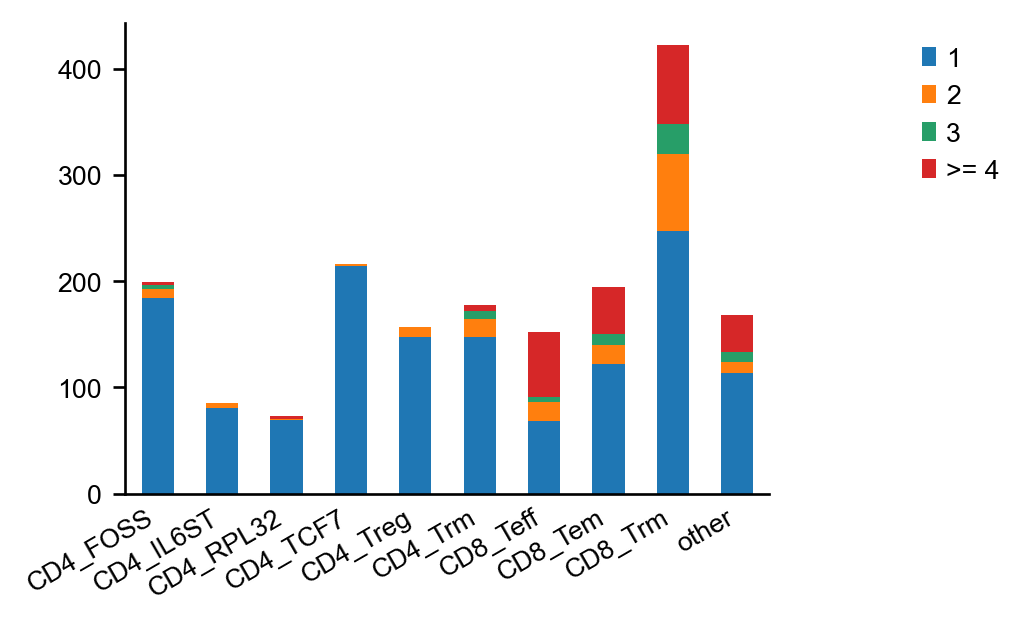

In [99]:
_ = ir.pl.clonal_expansion(
    mdata, target_col="clone_id", groupby="gex:cluster", clip_at=4, normalize=False
)

/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/scirpy/util/__init__.py:451: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return 1 / cast(np.ndarray, obs.groupby(normalize_col)[normalize_col].transform("count").values)


<Axes: >

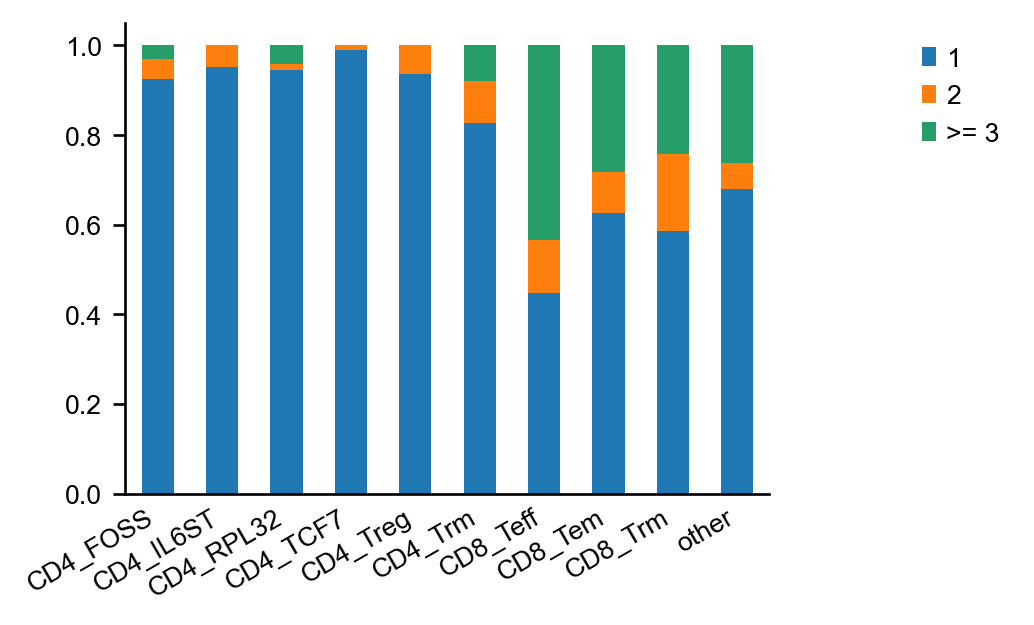

In [100]:
ir.pl.clonal_expansion(mdata, target_col="clone_id", groupby="gex:cluster")

The same plot, normalized to cluster size. Clonal expansion is a sign of positive selection for a certain, reactive T-cell clone. It, therefore, makes sense that CD8+ effector T-cells have the largest fraction of expanded clonotypes.

### Clonotype abundance

The function `scirpy.pl.group_abundance()` allows us to create bar charts for arbitrary categorial from obs. Here, we use it to show the distribution of them ten largest clonotypes across the cell-type clusters.

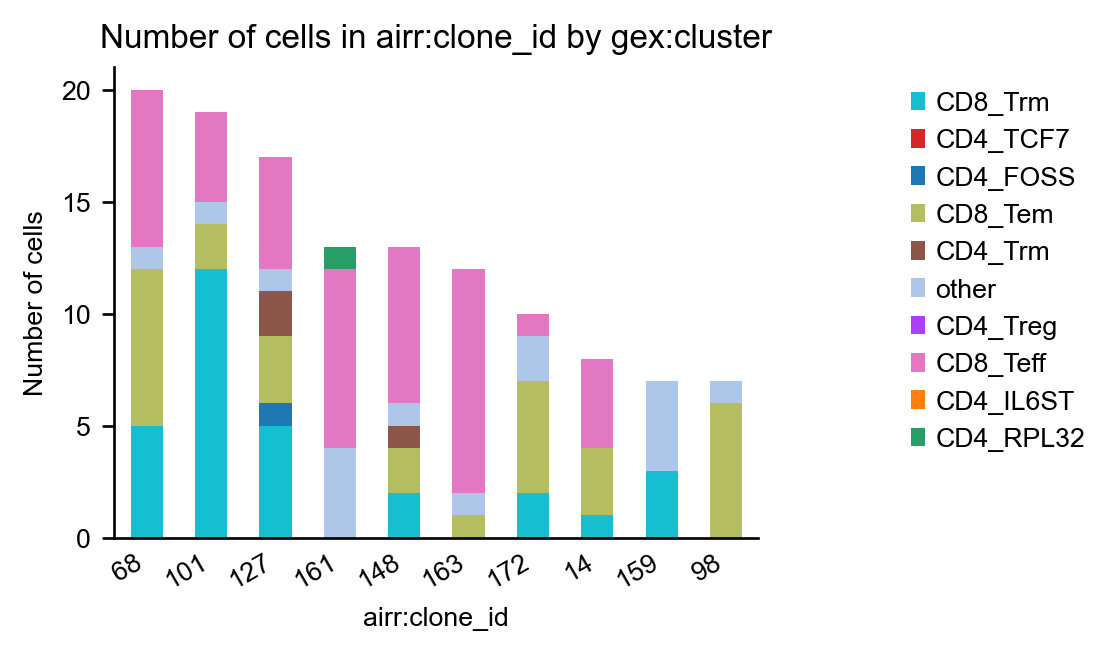

In [101]:
_ = ir.pl.group_abundance(
    mdata, groupby="airr:clone_id", target_col="gex:cluster", max_cols=10
)

It might be beneficial to normalize the counts to the number of cells per sample to mitigate biases due to different sample sizes:

/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/scirpy/util/__init__.py:451: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return 1 / cast(np.ndarray, obs.groupby(normalize_col)[normalize_col].transform("count").values)


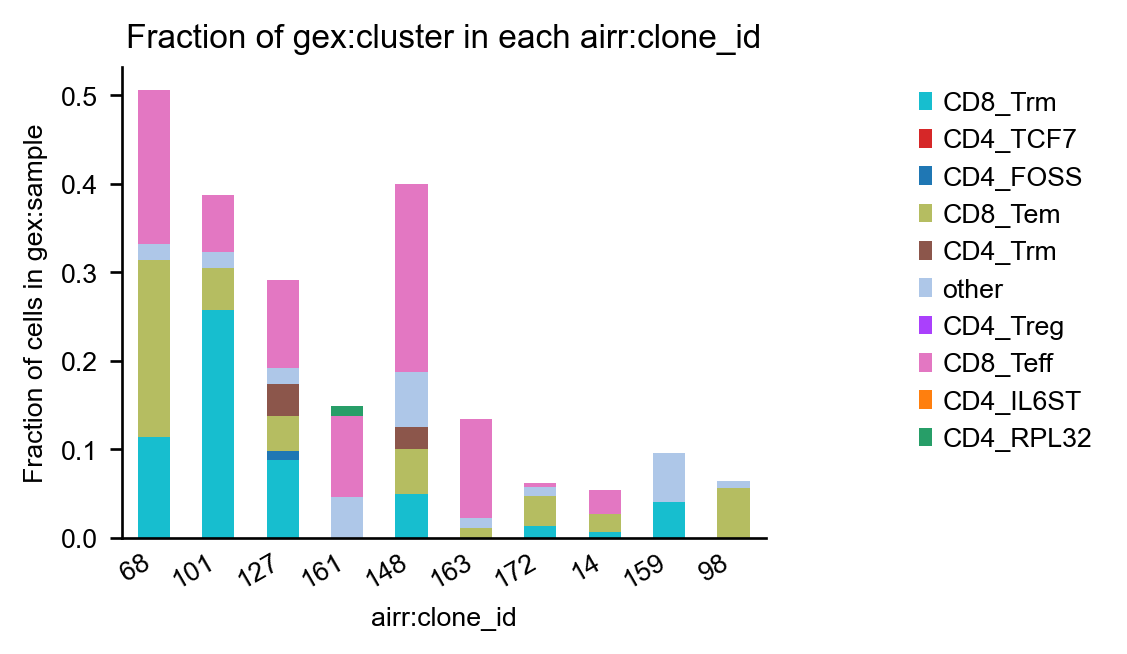

In [102]:
_ = ir.pl.group_abundance(
    mdata,
    groupby="airr:clone_id",
    target_col="gex:cluster",
    max_cols=10,
    normalize="gex:sample",
)

Coloring the bars by patient gives us information about public and private clonotypes: Some clonotypes are private, i.e. specific to a certain tissue, others are public, i.e. they are shared across different tissues.

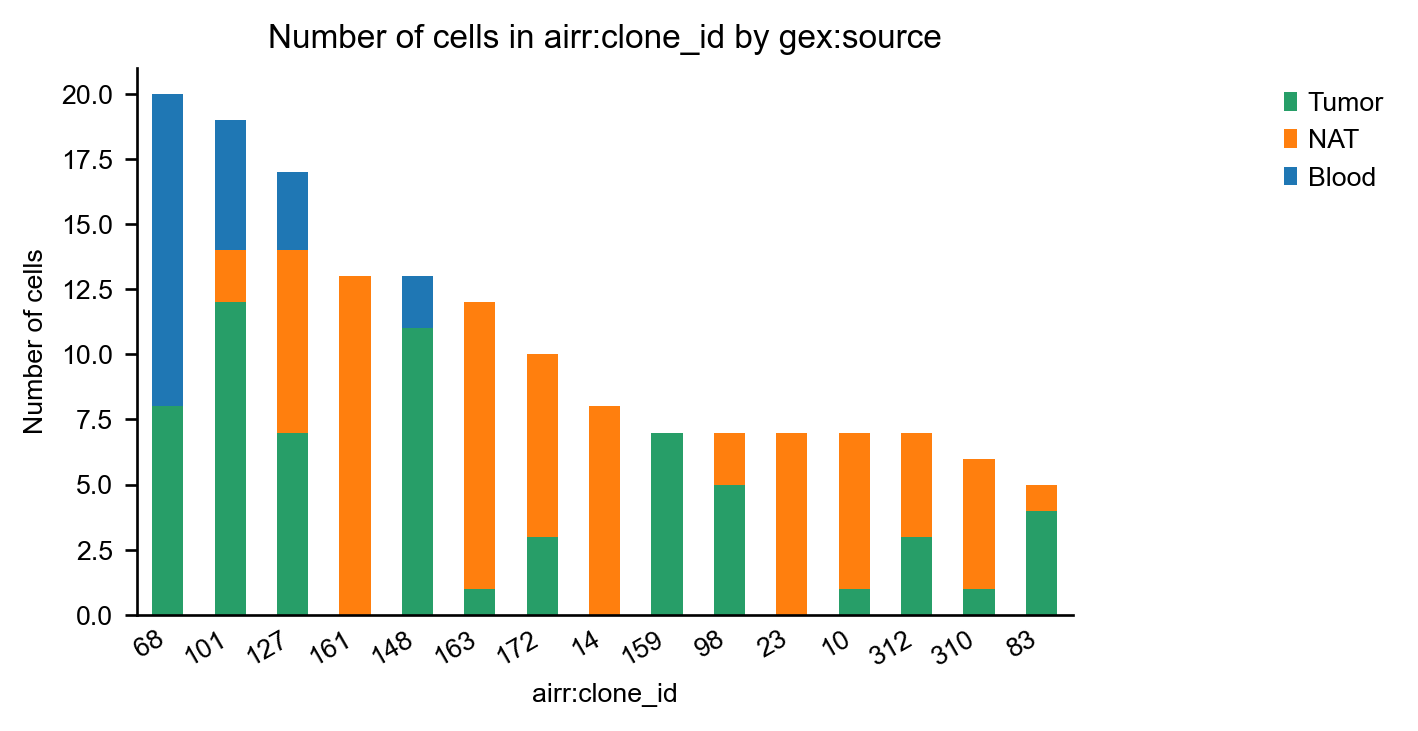

In [103]:
_ = ir.pl.group_abundance(
    mdata, groupby="airr:clone_id", target_col="gex:source", max_cols=15, figsize=(5, 3)
)

# Coloring the bars by patient gives us information about public and private clonotypes

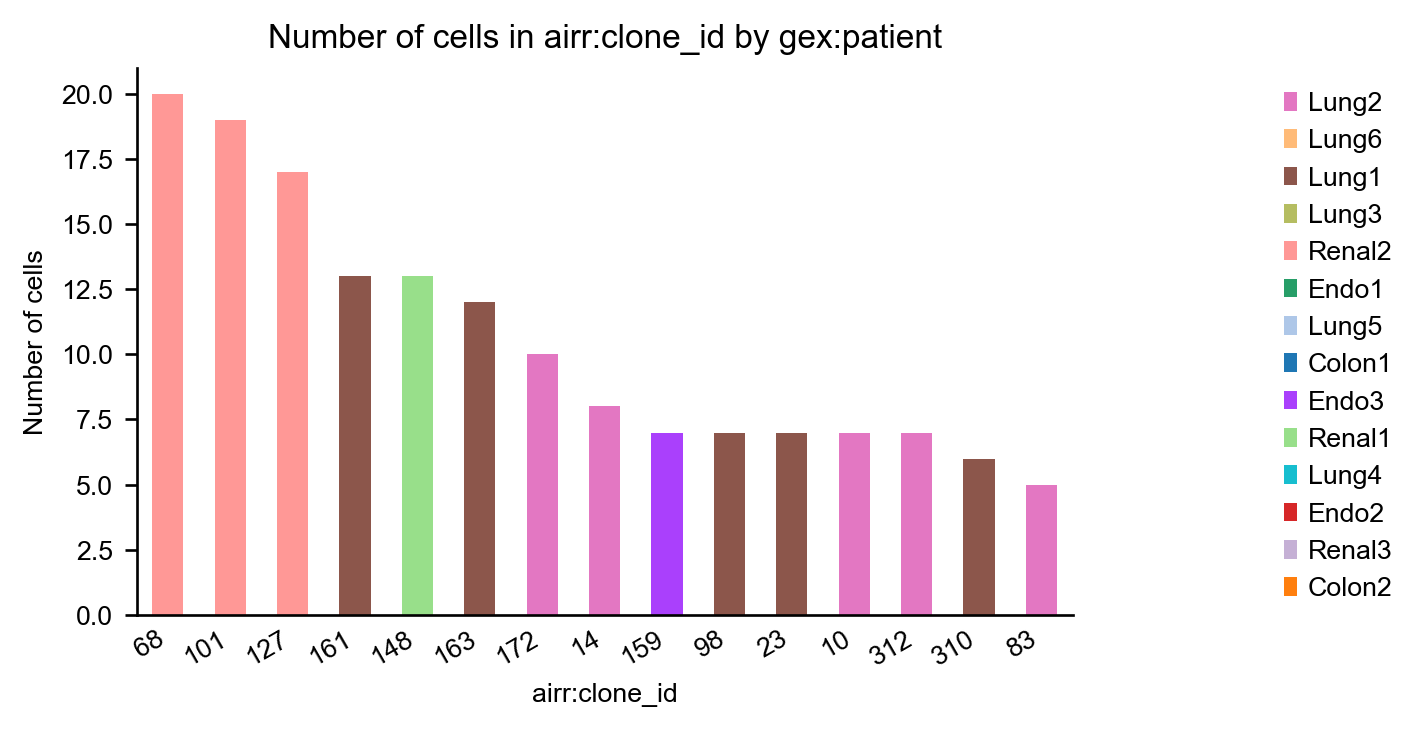

In [104]:
_ = ir.pl.group_abundance(
    mdata,
    groupby="airr:clone_id",
    target_col="gex:patient",
    max_cols=15,
    figsize=(5, 3),
)

# clonotypes that are shared between patients are rare:

### Convergent evolution

By comparing two levels of clonotype definitions (e.g. based on nucleotide sequences and based on amino-acid sequences), we can identify receptors that are subject to convergent evolution. By that, we mean receptors that (likely) recognize the same antigen but have evolved from different clones.

来自不同clonetype但能识别相同抗体

In [105]:
ir.tl.clonotype_convergence(mdata, key_coarse="cc_aa_alignment", key_fine="clone_id")

Stored result in `mdata.obs["airr:is_convergent"]`.


/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/scirpy/tl/_convergence.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs.groupby([key_coarse, key_fine], observed=True).size().reset_index().groupby(key_coarse).size().reset_index()


/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


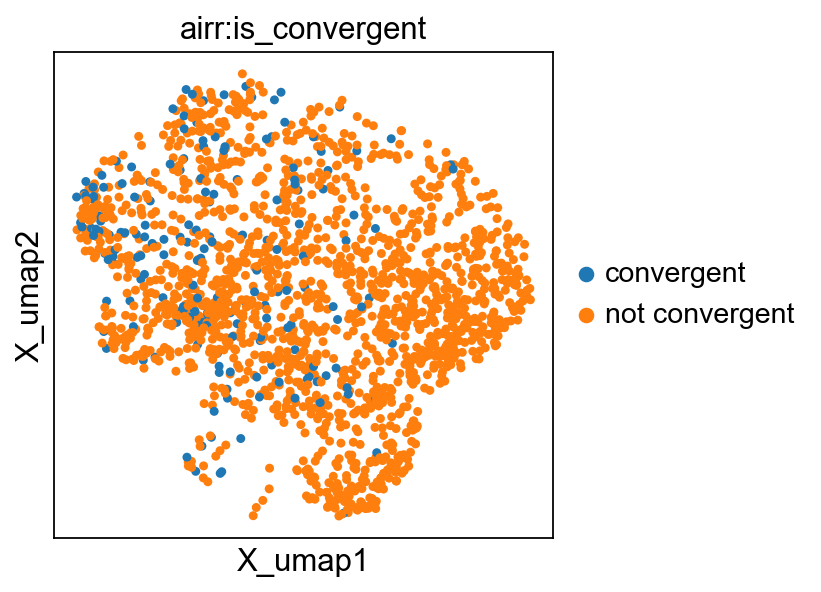

In [106]:
mu.pl.embedding(mdata, "gex:umap", color="airr:is_convergent")

## Gene usage

`scirpy.tl.group_abundance()` can also give us some information on VDJ usage. We first add information about v_call to obs using airr_context() and then generate a bar plot by the VJ_1_v_call variable. We use max_col to limit the plot to the 10 most abundant V-genes.

/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/scirpy/util/__init__.py:451: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return 1 / cast(np.ndarray, obs.groupby(normalize_col)[normalize_col].transform("count").values)


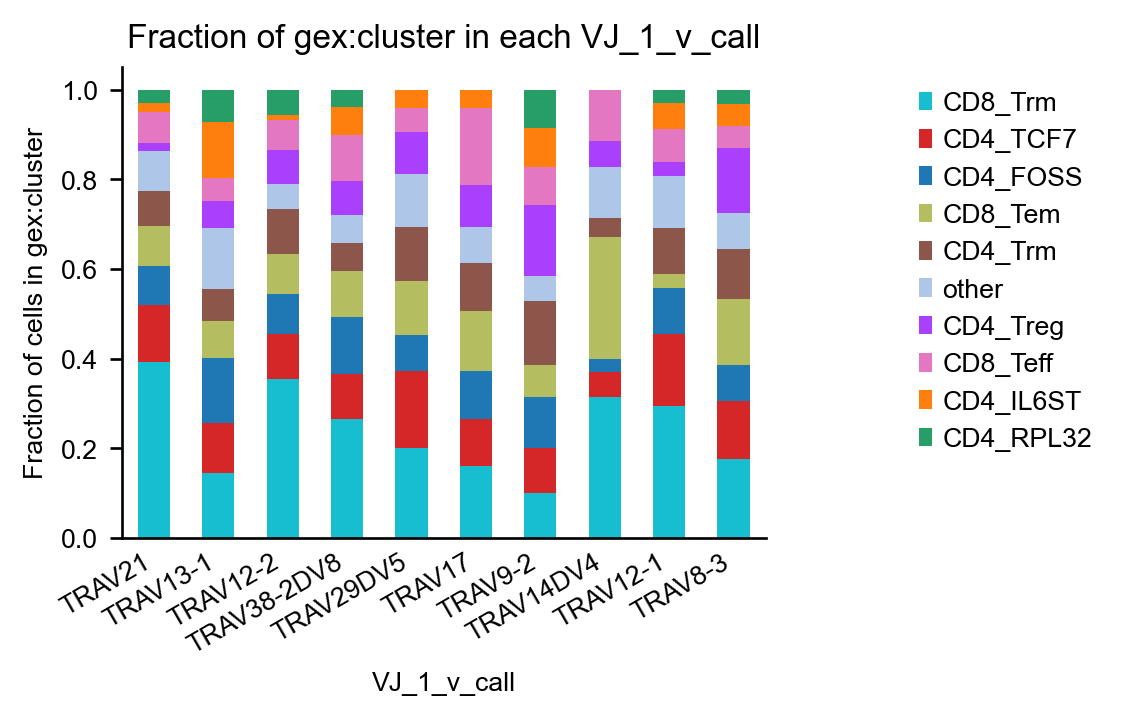

In [108]:
with ir.get.airr_context(mdata, "v_call"):
    ir.pl.group_abundance(
        mdata,
        groupby="VJ_1_v_call",
        target_col="gex:cluster",
        normalize=True,
        max_cols=10,
    )

/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/scirpy/util/__init__.py:451: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return 1 / cast(np.ndarray, obs.groupby(normalize_col)[normalize_col].transform("count").values)


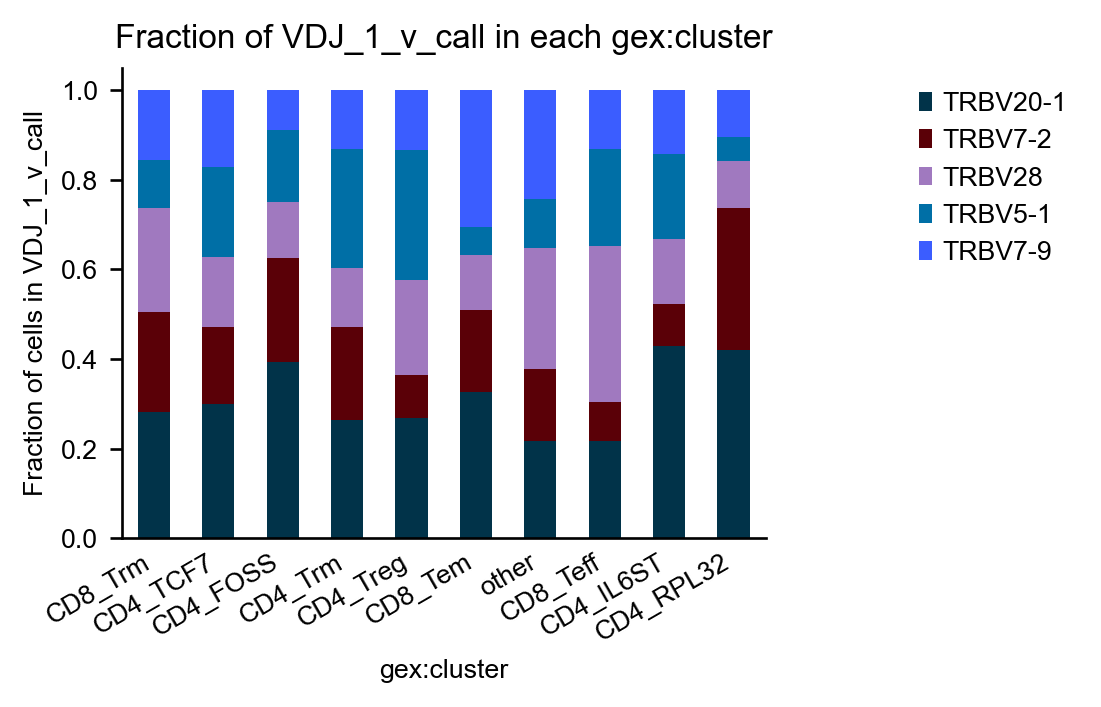

In [115]:
with ir.get.airr_context(mdata, "v_call"):
    ir.pl.group_abundance(
        mdata[
            mdata.obs["VDJ_1_v_call"].isin(
                ["TRBV20-1", "TRBV7-2", "TRBV28", "TRBV5-1", "TRBV7-9"]
            ),
            :,
        ],
        groupby="gex:cluster",
        target_col="VDJ_1_v_call",
        normalize=True,
    )

The exact combinations of VDJ genes can be visualized as a Sankey-plot using `scirpy.pl.vdj_usage()`

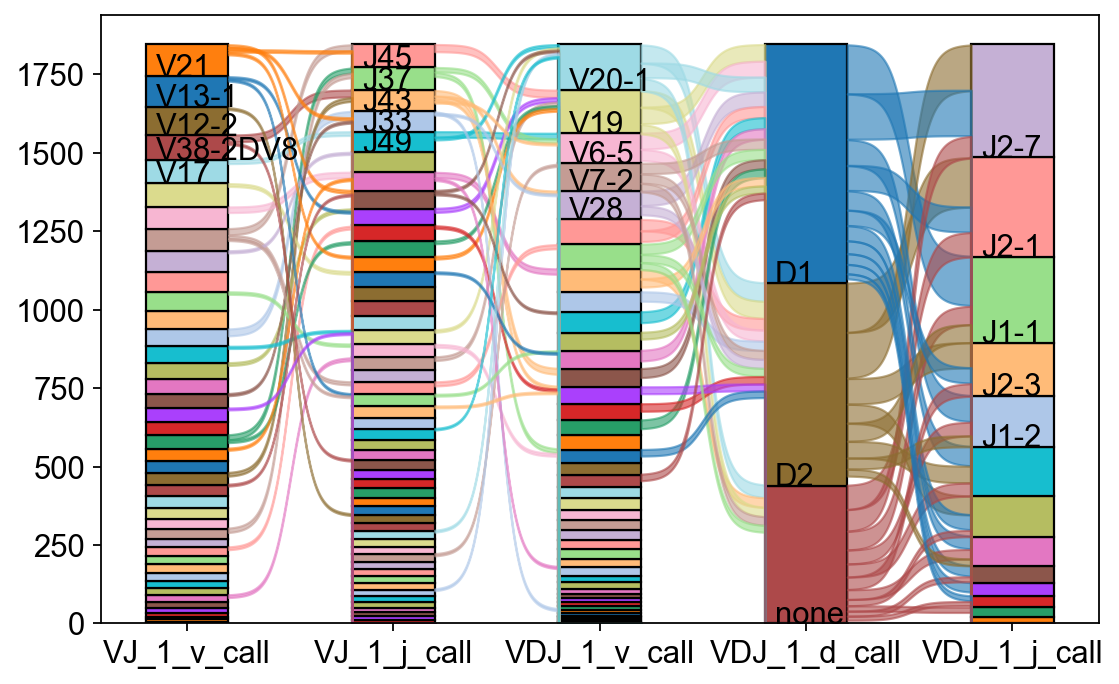

In [116]:
_ = ir.pl.vdj_usage(
    mdata,
    full_combination=False,
    max_segments=None,
    max_ribbons=30,
    fig_kws={"figsize": (8, 5)},
)

We can also use this plot to investigate the exact VDJ composition of one (or several) clonotypes

/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


<Axes: >

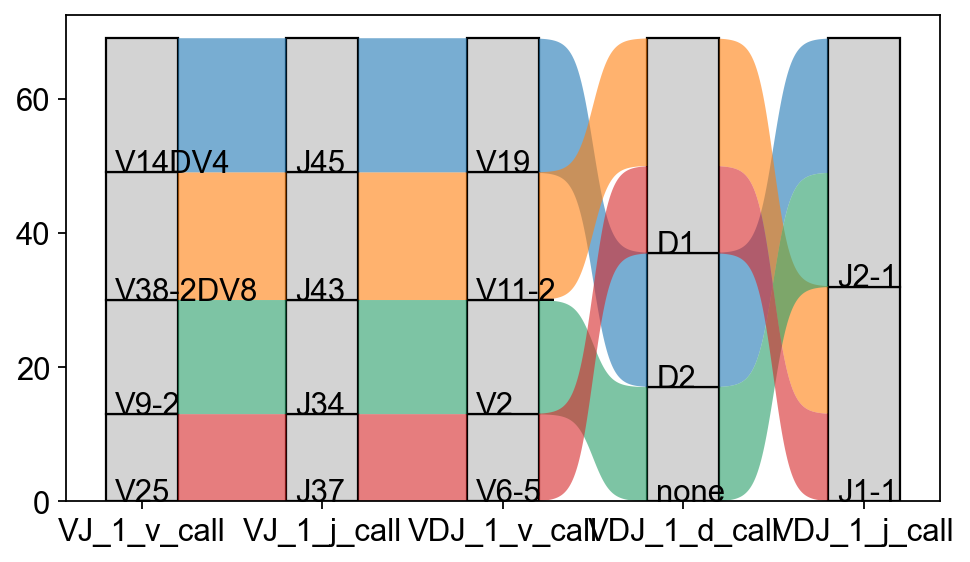

In [117]:
ir.pl.vdj_usage(
    mdata[mdata.obs["airr:clone_id"].isin(["68", "101", "127", "161"]), :],
    max_ribbons=None,
    max_segments=100,
)

### Spectratype plots

`spectratype()` plots give us information about the length distribution of CDR3 regions.

/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/scirpy/tl/_spectratype.py:75: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  obs["lengths"] = airr_df.applymap(len).apply(combine_fun, axis=1)


<Axes: title={'center': 'Spectratype of junction_aa by gex:cluster'}, xlabel='junction_aa length', ylabel='Number of cells'>

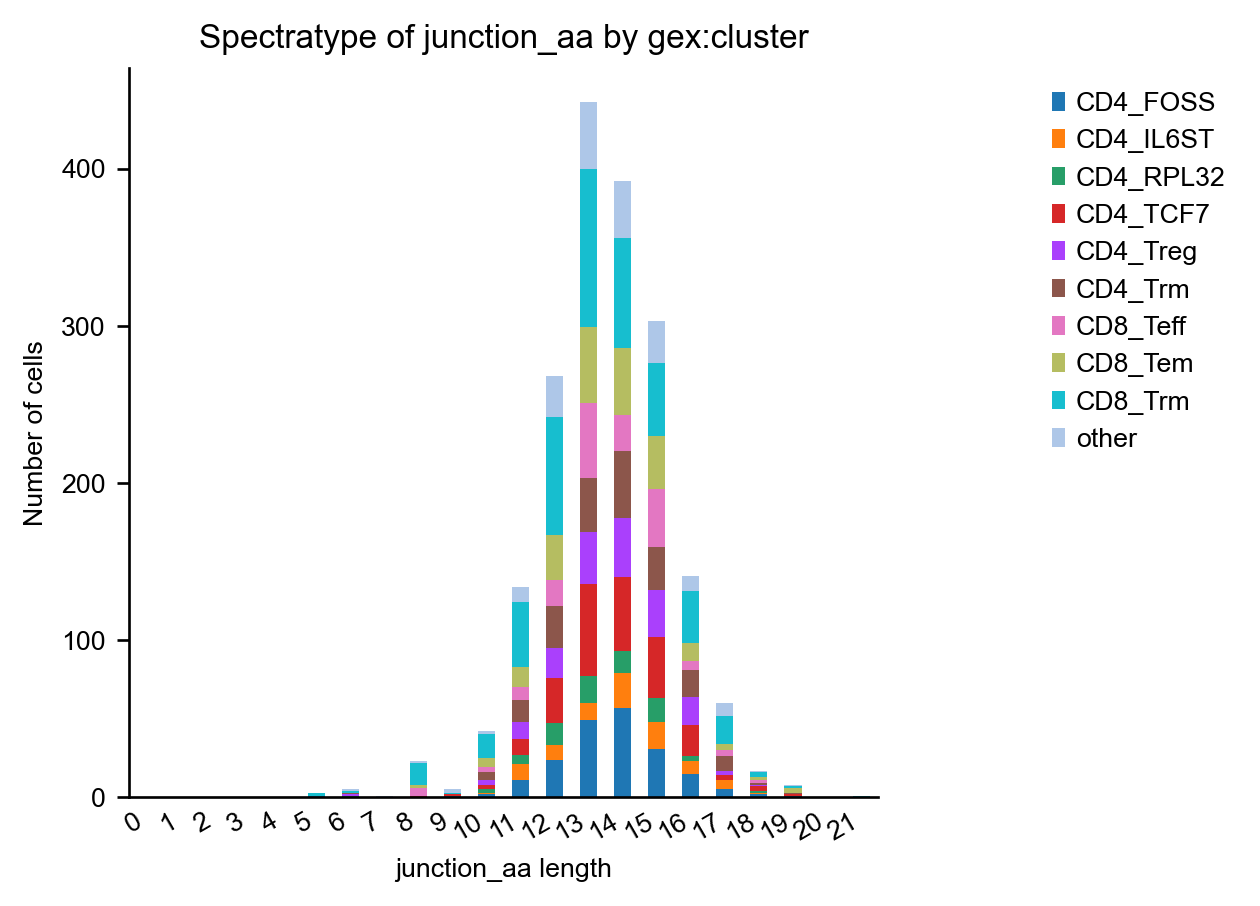

In [118]:
ir.pl.spectratype(mdata, color="gex:cluster", viztype="bar", fig_kws={"dpi": 120})

/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/scirpy/tl/_spectratype.py:75: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  obs["lengths"] = airr_df.applymap(len).apply(combine_fun, axis=1)
/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/scirpy/pl/base.py:261: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(order)


<Axes: title={'center': 'Spectratype of junction_aa by gex:cluster'}, xlabel='junction_aa length'>

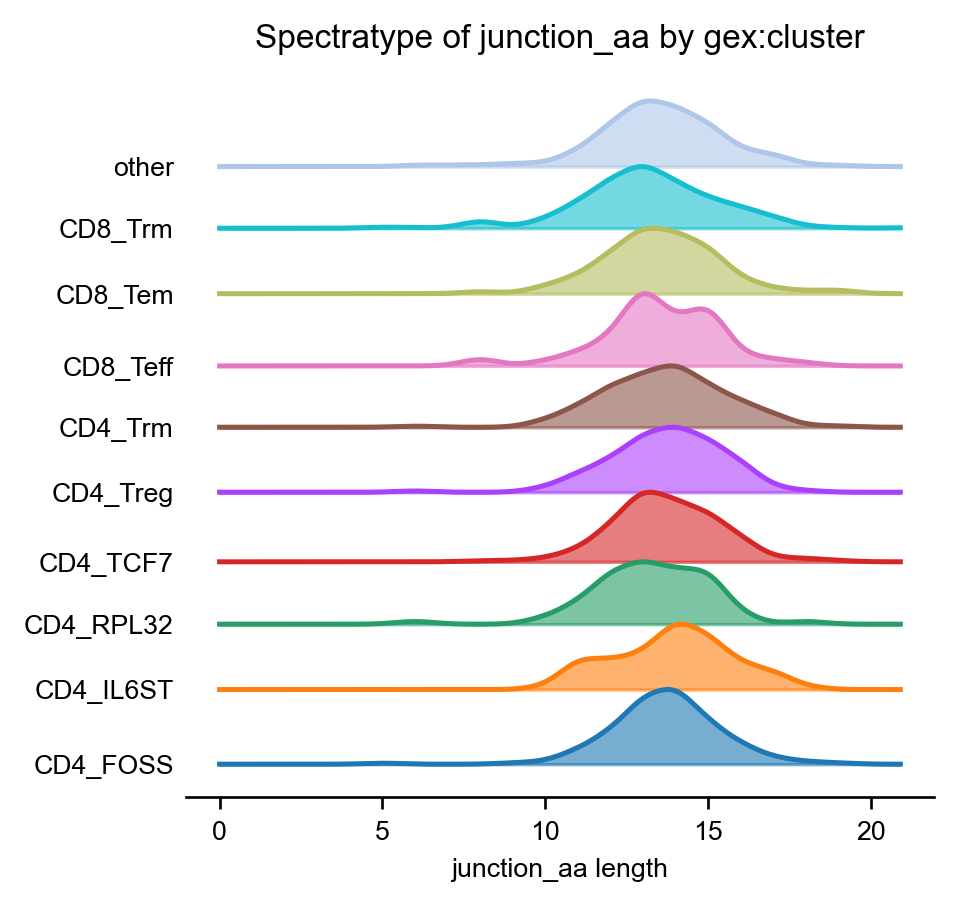

In [119]:
ir.pl.spectratype(
    mdata,
    color="gex:cluster",
    viztype="curve",
    curve_layout="shifted",
    fig_kws={"dpi": 120},
    kde_kws={"kde_norm": False},
)

In [120]:
# A spectratype-plot by gene usage. To pre-select specific genes, we can simply filter the mdata object before plotting.

with ir.get.airr_context(mdata, "v_call"):
    ir.pl.spectratype(
        mdata[
            mdata.obs["VDJ_1_v_call"].isin(
                ["TRBV20-1", "TRBV7-2", "TRBV28", "TRBV5-1", "TRBV7-9"]
            ),
            :,
        ],
        chain="VDJ_1",
        color="VDJ_1_v_call",
        normalize="gex:sample",
        fig_kws={"dpi": 120},

SyntaxError: incomplete input (539598394.py, line 13)

## Comparing repertoires

### Repertoire simlarity and overlaps

Overlaps in the adaptive immune receptor repertoire of samples or sample groups enables to pinpoint important clonotype groups, as well as to provide a measure of similarity between samples. Running Scirpy’s `repertoire_overlap()` tool creates a matrix featuring the abundance of clonotypes in each sample. Additionally, it also computes a (Jaccard) distance matrix of samples as well as the linkage of hierarchical clustering.

In [121]:
df, dst, lk = ir.tl.repertoire_overlap(mdata, "gex:sample", inplace=False)
df.head()

/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/scirpy/tl/_repertoire_overlap.py:85: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pr_df = df.applymap(lambda x: 1 if x > overlap_threshold else 0)


clone_id      0    1    2    3    4    5    6    7    8    9  ...  1516  1517  \
gex:sample                                                    ...               
RN2         1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
LN1         0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
LN2         0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  3.0  ...   0.0   0.0   
LN4         0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
LT6         0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   

clone_id    1518  1519  1520  1521  1522  1523  1524  1525  
gex:sample                                                  
RN2          0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0  
LN1          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
LN2          0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0  
LN4          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
LT6          1.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0  

[5 rows x 1526 columns]

/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/scirpy/tl/_repertoire_overlap.py:85: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pr_df = df.applymap(lambda x: 1 if x > overlap_threshold else 0)


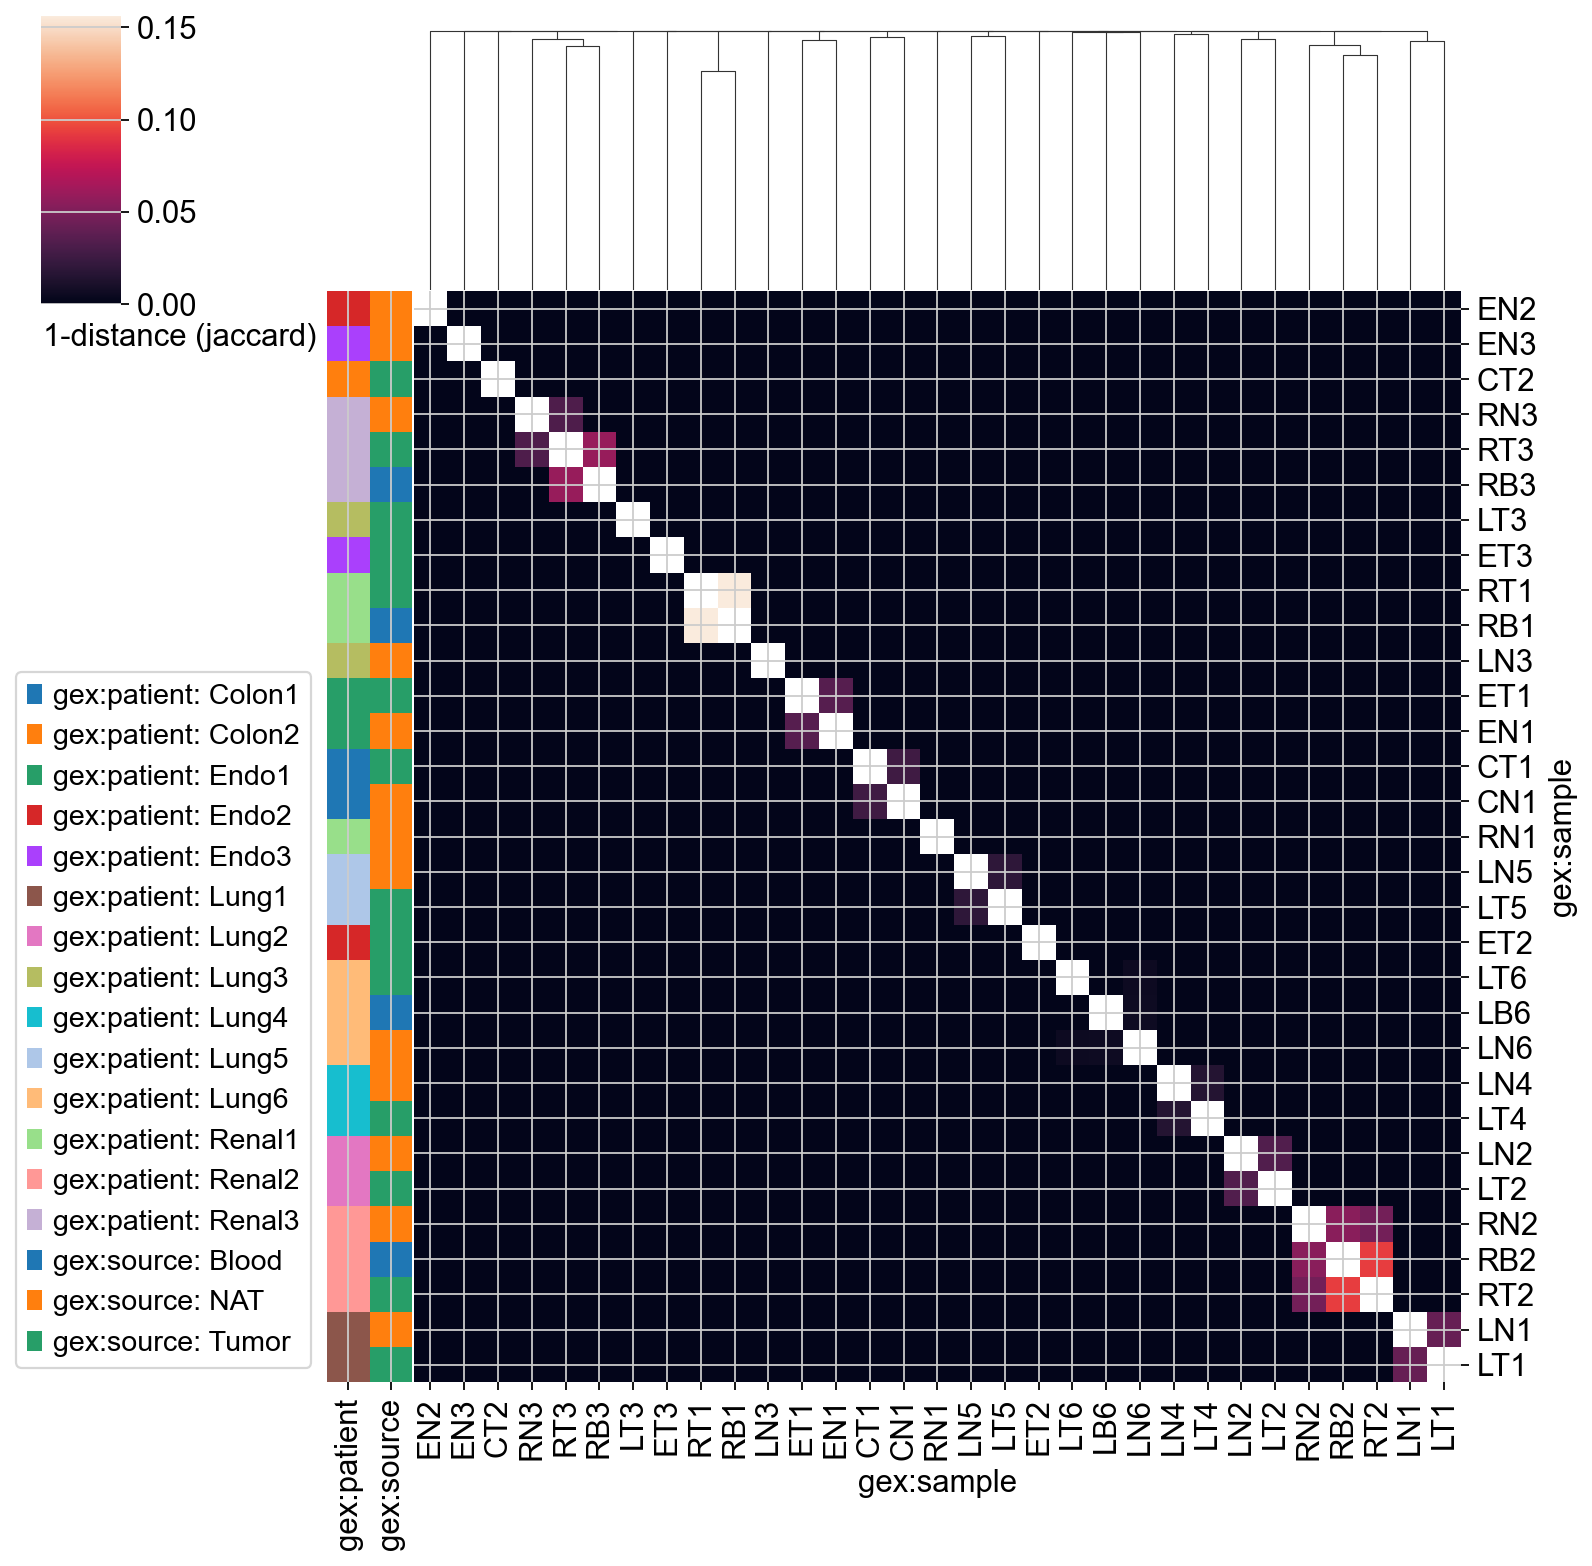

In [122]:
_ = ir.pl.repertoire_overlap(
    mdata,
    "gex:sample",
    heatmap_cats=["gex:patient", "gex:source"],
    yticklabels=True,
    xticklabels=True,
)

/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/scirpy/tl/_repertoire_overlap.py:85: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pr_df = df.applymap(lambda x: 1 if x > overlap_threshold else 0)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Axes: title={'center': 'Repertoire overlap between LN2 and LT2'}, xlabel='Clonotype size in LN2', ylabel='Clonotype size in LT2'>

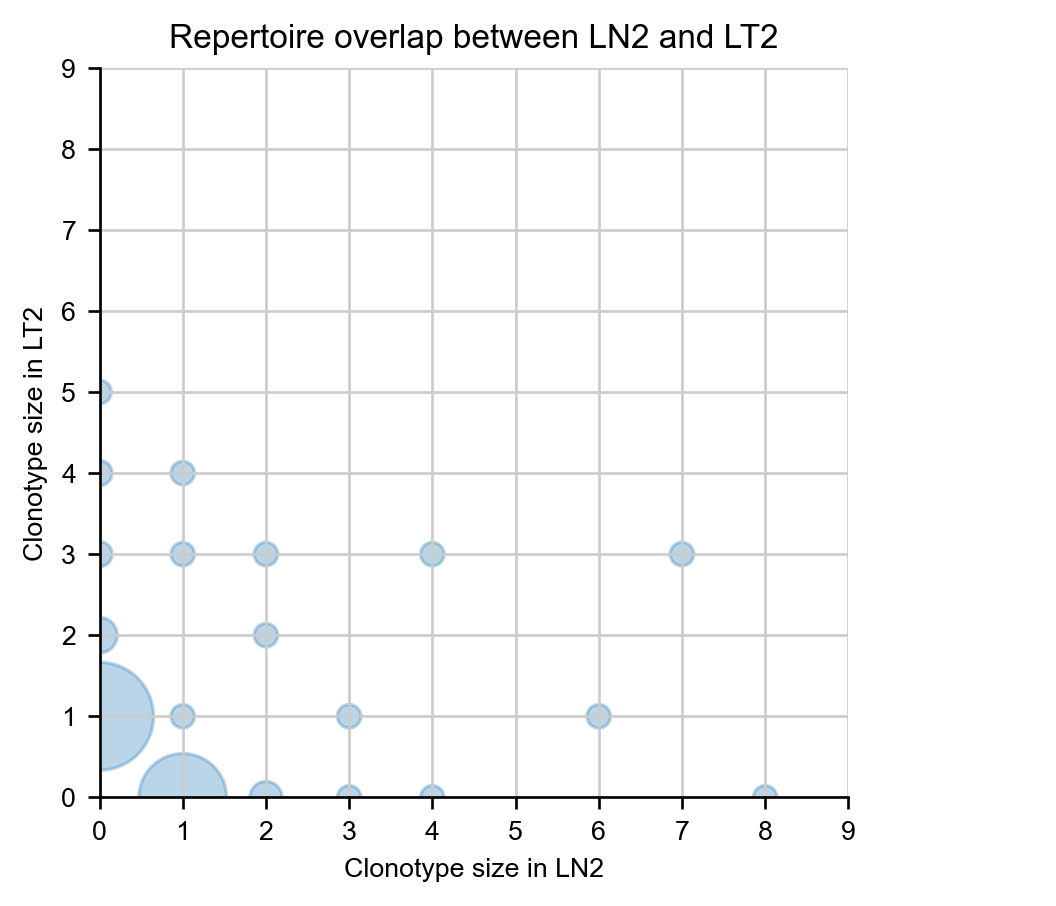

In [123]:
# A specific pair of samples can be compared on a scatterplot, where dot size corresponds to the number of clonotypes at a given coordinate.

ir.pl.repertoire_overlap(
    mdata, "gex:sample", pair_to_plot=["LN2", "LT2"], fig_kws={"dpi": 120}
)

## Integrating gene expression data

### Clonotype modularity

Using the Clonotype modularity we can identify clonotypes consisting of cells that are transcriptionally more similar than expected by random.

The clonotype modularity score represents the log2 fold change of the number of edges in the cell-cell neighborhood graph compared to the random background model. Clonotypes (or clonotype clusters) with a high modularity score consist of cells that have a similar molecular phenotype.

In [124]:
ir.tl.clonotype_modularity(mdata, target_col="airr:cc_aa_alignment")

Initalizing clonotype subgraphs...


/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
100%|██████████| 1487/1487 [00:00<00:00, 41788.76it/s]

Computing background distributions...



100%|██████████| 1000/1000 [00:00<00:00, 1270.18it/s]


Stored result in `mdata.obs["airr:clonotype_modularity"]`.
Stored result in `mdata.obs["airr:clonotype_modularity_fdr"]`.


/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


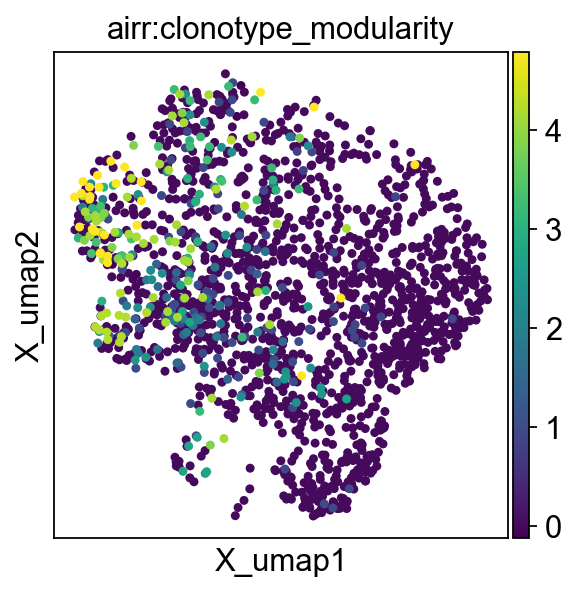

In [125]:
mu.pl.embedding(mdata, basis="gex:umap", color="airr:clonotype_modularity")

/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/scirpy/pl/_clonotypes.py:194: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(color_col) and color_col.nunique() >= 50:
/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/scirpy/pl/_clonotypes.py:466: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if isinstance(color, str) and color in obs and not is_categorical_dtype(obs[color]):


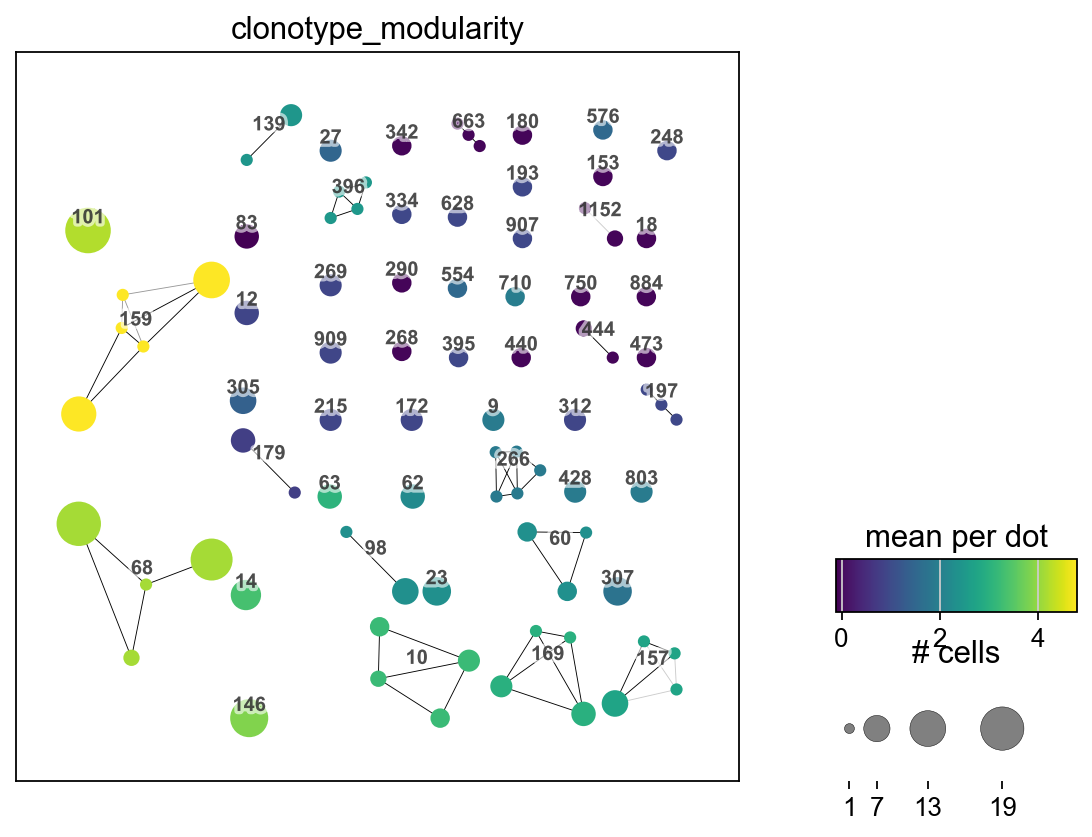

In [126]:
_ = ir.pl.clonotype_network(
    mdata,
    color="clonotype_modularity",
    label_fontsize=9,
    panel_size=(6, 6),
    base_size=20,
)

<Axes: xlabel='modularity score', ylabel='-log10(FDR)'>

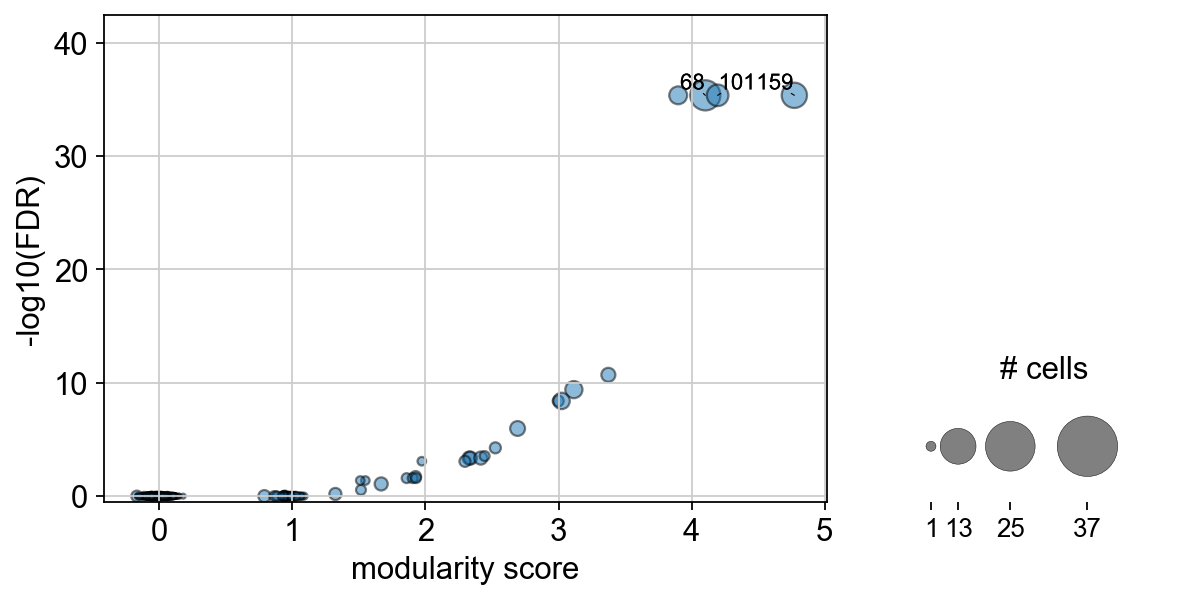

In [127]:
# We can also visualize the clonotype modularity together with the associated FDR as a sort of “one sided volcano plot”

ir.pl.clonotype_modularity(mdata, base_size=20)

In [128]:
clonotypes_top_modularity = list(
    mdata.obs.set_index("airr:cc_aa_alignment")["airr:clonotype_modularity"]
    .sort_values(ascending=False)
    .index.unique()
    .values[:2]
)

In [129]:
clonotypes_top_modularity

['159', '101']

/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1169: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if groups and is_categorical_dtype(values):
/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/mowp/mambaforge

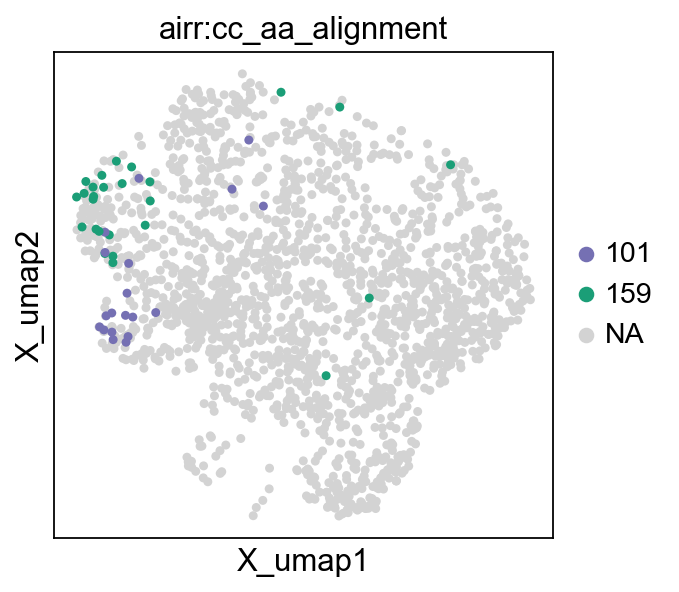

In [141]:
test_ad = mu.pl.embedding(
    mdata,
    basis="gex:umap",
    color="airr:cc_aa_alignment",
    groups=clonotypes_top_modularity,
    palette=cycler(color=mpl_cm.Dark2_r.colors),
)

We observe that they are (mostly) restricted to a single cluster. By leveraging scanpy’s differential expression module, we can compare the gene expression of the cells in the two clonotypes to the rest.

ranking genes


/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


    finished (0:00:00)


/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future v

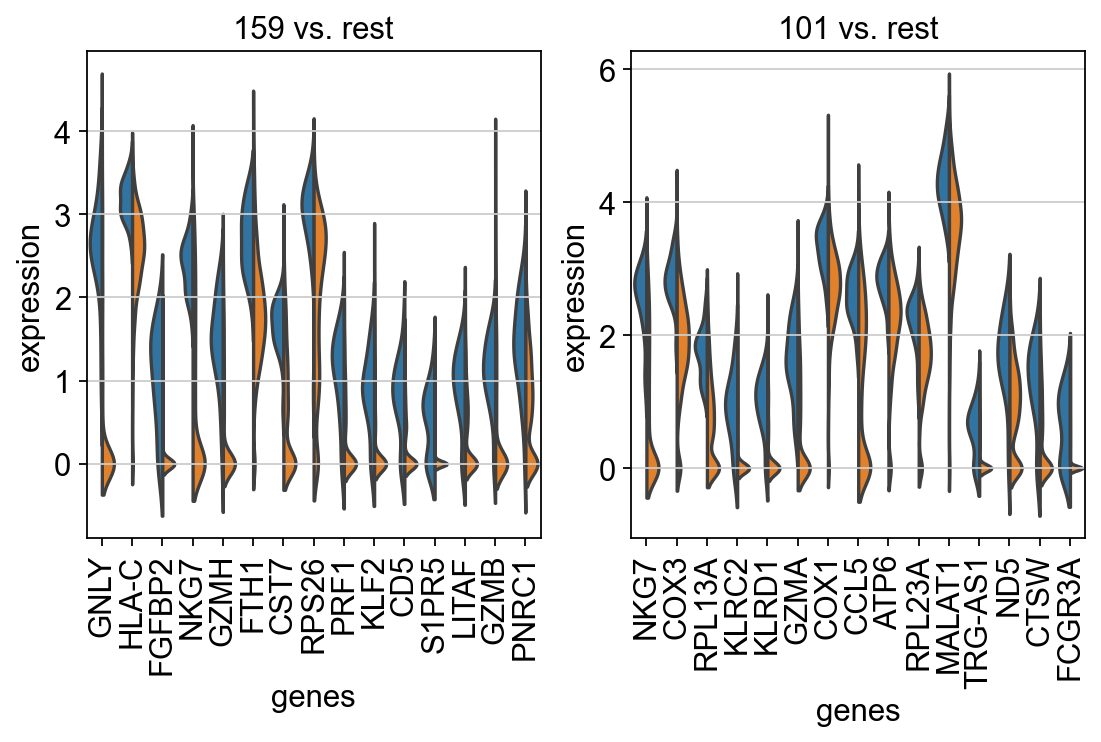

In [131]:
# Since sc.tl.rank_genes_group does not support MuData, we need to temporarily add
# the AIRR columns to the gene expression AnnData object
with ir.get.obs_context(
    mdata["gex"], {"cc_aa_alignment": mdata.obs["airr:cc_aa_alignment"]}
) as tmp_ad:
    sc.tl.rank_genes_groups(
        tmp_ad,
        "cc_aa_alignment",
        groups=clonotypes_top_modularity,
        reference="rest",
        method="wilcoxon",
    )
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    for ct, ax in zip(clonotypes_top_modularity, axs):
        sc.pl.rank_genes_groups_violin(
            tmp_ad, groups=[ct], n_genes=15, ax=ax, show=False, strip=False
        )

### Clonotype imbalance among cell clusters

Using cell type annotation inferred from gene expression clusters, for example, clonotypes belonging to CD8+ effector T-cells and CD8+ tissue-resident memory T cells, can be compared.

In [133]:
freq, stat = ir.tl.clonotype_imbalance(
    mdata,
    replicate_col="gex:sample",
    groupby="gex:cluster",
    case_label="CD8_Teff",
    control_label="CD8_Trm",
    inplace=False,
)
top_differential_clonotypes = stat["clone_id"].tolist()[:3]

/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/scirpy/tl/_repertoire_overlap.py:85: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pr_df = df.applymap(lambda x: 1 if x > overlap_threshold else 0)
/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/scirpy/tl/_clonotype_imbalance.py:273: RuntimeWarning: divide by zero encountered in log2
  logfoldchange = np.log2((case_mean_freq + global_minimum) / (control_mean_freq + global_minimum))
/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/scirpy/tl/_clonotype_imbalance.py:273: RuntimeWarning: divide by zero encountered in scalar divide
  logfoldchange = np.log2((case_mean_freq + global_minimum) / (control_mean_freq + global_minimum))


/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.p

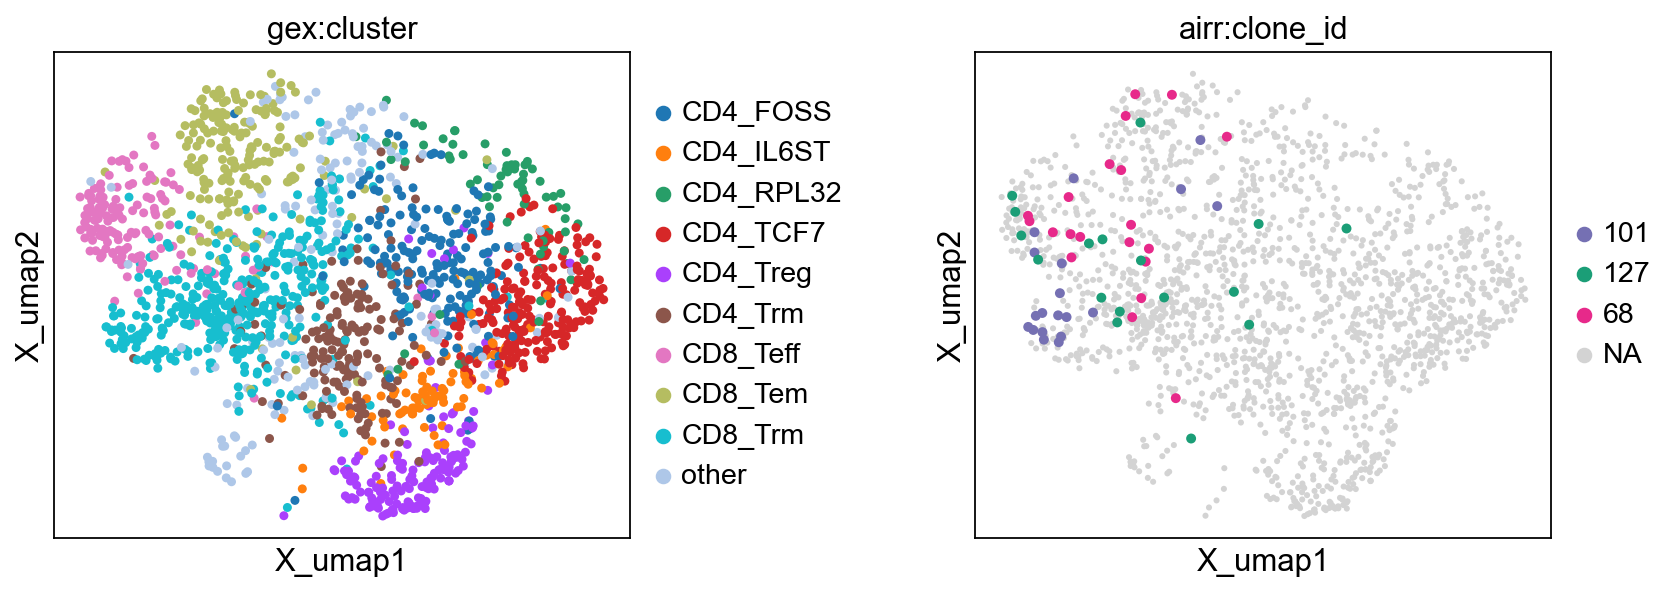

In [140]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={"wspace": 0.6})
mu.pl.embedding(mdata, basis="gex:umap", color="gex:cluster", ax=ax1, show=False)
mu.pl.embedding(
    mdata,
    basis="gex:umap",
    color="airr:clone_id",
    groups=top_differential_clonotypes,
    ax=ax2,
    # increase size of highlighted dots
    size=[
        80 if c in top_differential_clonotypes else 30
        for c in mdata.obs["airr:clone_id"][mdata.mod["gex"].obs_names]
    ],
    palette=cycler(color=mpl_cm.Dark2_r.colors),
)

### Marker genes in top clonotypes

Gene expression of cells belonging to individual clonotypes can also be compared using Scanpy. As an example, differential gene expression of two clonotypes, found to be specific to cell type clusters can also be analysed.

ranking genes
    finished (0:00:00)


/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mowp/mambaforge/envs/scirpy/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: Fut

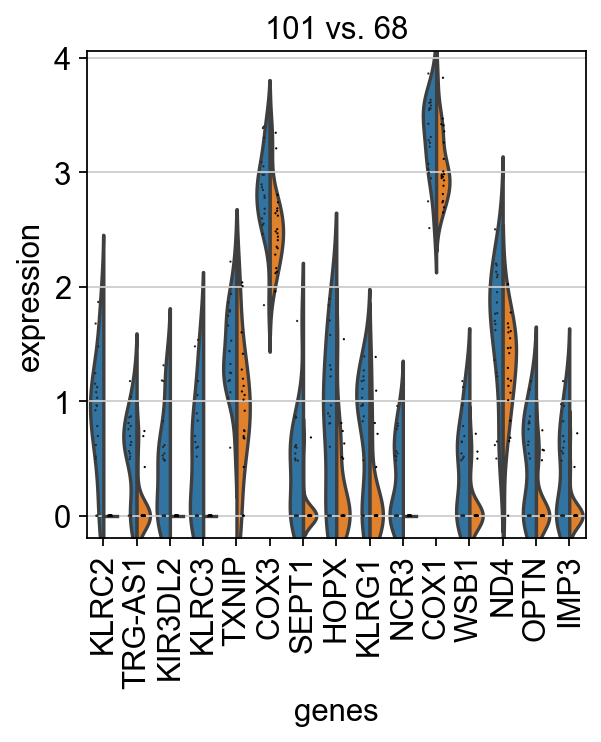

In [138]:
with ir.get.obs_context(
    mdata["gex"], {"clone_id": mdata.obs["airr:clone_id"]}
) as tmp_ad:
    sc.tl.rank_genes_groups(
        tmp_ad, "clone_id", groups=["101"], reference="68", method="wilcoxon"
    )
    sc.pl.rank_genes_groups_violin(tmp_ad, groups="101", n_genes=15)

## Query epitope databases

We can use scirpy to query reference databases or datasets to annotate IRs with certain features, such as epitope specificity. The reference database can be any dataset in scirpy’s AnnData format and you can follow the instructions in the data loading tutorial to build a custom reference database, if it is not available from scirpy.datasets yet.

In [144]:
vdjdb = ir.datasets.vdjdb()

URLError: <urlopen error [Errno 111] Connection refused>

In [145]:
ir.pp.ir_dist(mdata, vdjdb, metric="identity", sequence="aa")

NameError: name 'vdjdb' is not defined